# Models

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels as sms

import numpy as np
from scipy.stats import norm, truncnorm
from scipy.stats import beta

from tqdm.notebook import tqdm


class QLearningModule:
    def __init__(self, *args, **kwargs):
        self.lr = kwargs.get('lr', .5)
        self.rl_temp = kwargs.get('rl_temp', 1)
        n_states, n_actions = kwargs.get(
            'n_states', 2), kwargs.get('n_actions', 2)
        self.q = np.ones((n_states, n_actions)) * kwargs.get('q0', 50)

    def value_update(self, s, a, r):
        self.q[s, a] += self.lr * (r - self.q[s, a])


class PerceptualLogit:
    def __init__(self, *args, **kwargs):
        self.perceptual_temp = kwargs.get('perceptual_temp', 1)
        self.perceptual_model = kwargs.get('perceptual_model', 'logit')
        self.x = kwargs.get('x', np.arange(-1, 1, .2))

        self.firth_fit = None
        self.logit_fit = None
        # history of forcefields
        self.hist_ff = []
        # history of rewards (destroyed or not)
        self.hist_r = []

    def predictff(self, ff1=None, ff2=None):

        model = self.perceptual_model

        if ff1 is not None and ff2 is not None:
            x = np.arange(len(self.x))
            to_select = np.array([x[self.x == ff1][0], x[self.x == ff2][0]])
        else:
            # to_select = np.arange(len(self.x))
            to_select = np.arange(len(np.unique(self.hist_ff)))
        if model == 'logit':
            try:
                self.logit_fit = sm.Logit(self.hist_r, sm.add_constant(self.hist_ff))\
                    .fit_regularized(disp=0, start_params=[0, 0])

                return self.logit_fit.predict(sm.add_constant(self.x))[to_select]
            # catch separation error and value errrors
            except (sms.tools.sm_exceptions.PerfectSeparationError,
                    ValueError, np.linalg.LinAlgError):
                # equal probability for all forcefields
                try:
                    return 1/len(to_select) * np.ones(len(to_select))
                except ZeroDivisionError:
                    return

        elif model == 'firth':
            try:
                self.firth_fit = FirthLogisticRegression(skip_ci=True, wald=False, fit_intercept=True)\
                    .fit(sm.add_constant(self.hist_ff), self.hist_r)
                return self.firth_fit.predict(sm.add_constant(np.unique(self.hist_ff)))[to_select]
            except:
                return 1/len(to_select) * np.ones(len(to_select))
        else:
            raise ValueError(
                'model must be either logit, firth, or val. Model is {}'.format(model))

    def get_intercept_and_slope(self):
        model = self.perceptual_model
        if model == 'logit':
            if self.logit_fit is None:
                self.predictff()
                if self.logit_fit is None:
                    return np.array([0, 0])
            return np.clip(self.logit_fit.params, -10, 10)
        # elif model=='linear':
            # return
        elif model == 'firth':
            return np.array(self.firth_fit.coef_)
        elif model == 'val':
            return self.val_fit
        else:
            raise ValueError('model must be either logit or linear')


class LogitRLEV(PerceptualLogit, QLearningModule):
    def __init__(self, *args, **kwargs):
        PerceptualLogit.__init__(self, *args, **kwargs)
        QLearningModule.__init__(self, *args, **kwargs)

    def make_choice(self, s, ff1, ff2):
        def logsumexp(x):
            c = x.max()
            return c + np.log(np.sum(np.exp(x - c)))

        pdestroy = 1

        if ff1 is not None and ff2 is not None:
            pdestroy = self.predictff(ff1=ff1, ff2=ff2)

        x = ((self.q[s, :] * self.rl_temp)
             * (pdestroy
             * self.perceptual_temp))

        p = np.exp(x - logsumexp(x))

        return np.random.choice(np.arange(2), p=p)

    def learn_perceptual(self, a, r):
        self.hist_ff.append(a)
        self.hist_r.append(r)
        self.predictff()

    def learn_value(self, s, a, r):
        self.value_update(s, a, r)

    def get_params(self, s=None):
        intercept, slope = self.get_intercept_and_slope()
        return {
            # alpha logit (utf8 character symbol as key)
            'α': intercept,
            # beta logit
            'β': slope,
            # alpha qlearning
            'lr': self.lr,
            # temperature qlearning
            'rl_temp': self.rl_temp,
            # temperature logit
            'perceptual_temp': self.perceptual_temp
        }


class RLLogitLogRatio(QLearningModule, PerceptualLogit):
    def __init__(self, *args, **kwargs):
        QLearningModule.__init__(self, *args, **kwargs)
        PerceptualLogit.__init__(self, *args, **kwargs)

    def make_choice(self, s, ff1, ff2):
        def logsumexp(x):
            c = x.max()
            return c + np.log(np.sum(np.exp(x - c)))

        x1 = np.log(self.q[s, :]) * self.rl_temp
        x2 = np.log(self.predictff(ff1=ff1, ff2=ff2)) * self.perceptual_temp
        x = x1 + x2

        p = np.exp(x - logsumexp(x))

        try:
            return np.random.choice(np.arange(2), p=p)
        except ValueError as e:
            print(e)
            return np.random.choice(np.arange(2), p=[0.5, 0.5])


class NormativePerceptual:
    def __init__(self, *args, **kwargs):
        # super().__init__(*args, **kwargs)
        # slope prior
        self.slope_prior = kwargs.get('slope_prior', 2)
        # leak parameter
        self.leak = kwargs.get('leak', 0)
        # x values = forcefield values
        self.x = kwargs.get('x', np.linspace(-1, 1, 12))

        if not isinstance(self.x, np.ndarray):
            self.x = np.array(list(self.x))

        # possible values for the slope
        self.slope_range = kwargs.get(
            'slope_range', np.arange(-10, 10, 0.002))

        # initialize logposterior for the slope to prior
        self.lp_slope = np.log(norm.pdf(self.slope_range, 0, self.slope_prior))

        # define logit function
        self.logit = lambda x: 1 / (1+np.exp(x))

    def perceptual_update(self, choice, destroyed):
        v = self.slope_range*choice; v = v - v * 2 * destroyed # switch to negative if ff destroyed
        # compute log likelihood
        ll = np.log(self.logit(v))
        # update log posterior
        self.lp_slope += ll
        self._apply_leak_perceptual()

    def predictff(self, ff1=None, ff2=None):
        if ff1 is None and ff2 is None:
            # predict p(destroy) for all forcefields
            to_select = np.arange(len(self.x))
        else:
            # predict p(destroy) for 2 (displayed) forcefields
            x = np.arange(len(self.x))
            to_select = np.array([x[self.x == ff1][0], x[self.x == ff2][0]])

        return self.logit(-self.get_slope()*self.x[to_select])

    def get_slope(self):
        w = np.exp(self.lp_slope-np.max(self.lp_slope))
        slope = np.sum(w*self.slope_range)/np.sum(w)
        return slope
    #

    def _apply_leak_perceptual(self):
        self.lp_slope *= 1-self.leak


class NormativeValue:
    def __init__(self, *args, **kwargs):
        # super().__init__(*args, **kwargs)
        self.delta_prior = kwargs.get('delta_prior', .2)
        self.std_prior = kwargs.get('std_prior', .2)
        self.leak = kwargs.get('leak', 0)
        self.nstate = kwargs.get('nstate', 2)

        # possible values for the difference between two options
        self.delta_range = kwargs.get('delta_range', np.arange(-1, 1, 0.002))

        # initialize logposterior for the slope to prior
        self.lp_delta = [
            np.log(tnormpdf(0.5*(1+self.delta_range), 0.5, self.delta_prior))
            for _ in range(self.nstate)
        ]

    def value_update(self, s, a, r):
        v = 1-self.delta_range if a else 1+self.delta_range
        # compute log likelihood
        ll = np.log(tnormpdf(r, 0.5*(v), self.std_prior))
        # update log posterior
        self.lp_delta[s] += ll
        self._apply_leak_value(s)

    def get_delta(self, s):
        w = np.exp(self.lp_delta[s]-np.max(self.lp_delta[s]))
        delta = np.sum(w*self.delta_range)/np.sum(w)
        return delta

    def _apply_leak_value(self, s):
        self.lp_delta[s] *= 1-self.leak


class Normative(NormativeValue, NormativePerceptual):
    def __init__(self, *args, **kwargs):
        NormativeValue.__init__(self, *args, **kwargs)
        NormativePerceptual.__init__(self, *args, **kwargs)

        self.temp = kwargs.get('temp', 1e6)

    def make_choice(self, s, ff1, ff2):
        # default is EV decision
        p = self.predictff(ff1, ff2) if ff1 is not None else 1
        ev1, ev2 = (
            (.5 * (1+self.get_delta(s)*(np.array([1, -1])))) * p)
        choice = np.random.random() > 1/(1+np.exp(-self.temp*(ev1-ev2)))
        return choice

    def learn_perceptual(self, a, r):
        self.perceptual_update(a, r)

    def learn_value(self, s, a, r):
        self.value_update(s, a, r)

    def get_params(self, s=None):
        return {
            # beta logit (utf8 character symbol as key)
            'β': self.get_slope(),
            # delta (diff between two options) (utf8 character symbol as key)
            '$\delta$': self.get_delta(s) if s is not None
            else [self.get_delta(s) for s in range(self.nstate)],
        }


class NormativeEV(Normative,
                  NormativeValue, NormativePerceptual):
    def ll_of_choice(self, ff1, ff2, s, a):
        p1 = self.predictff(ff1, ff2) if ff1 is not None else 1
        ev1, ev2 = (
            (.5 * (1+self.get_delta(s)*(np.array([1, -1])))) * p1)
        p1 = 1/(1+np.exp(-self.temp*(ev1-ev2)))
        p = [p1, 1-p1]
        if p[a] == 0:
            p[a] += 1e-8
        return p[a]


class NormativeLogRatio(Normative,
                        NormativeValue, NormativePerceptual):
    def __init__(self, *args, **kwargs):
        Normative.__init__(self, *args, **kwargs)
        self.perceptual_temp = kwargs.get('perceptual_temp', 1e6)
        self.rl_temp = kwargs.get('rl_temp', 1e6)

    def make_choice(self, s, ff1, ff2):
        p = np.log(self.predictff(ff1, ff2)) if ff1 is not None else np.array([1, 1])
        ev = np.log(
            (.5 * (1+self.get_delta(s)*(np.array([1, -1]))))
        )
        dv = ev[0] - ev[1]
        dp = p[0] - p[1]
        x = (
            np.array([dv, dp]) *
            np.array([self.rl_temp, self.perceptual_temp])
        ).sum()
        choice = int(np.random.random() > 1/(1+np.exp(-x)))
        return choice

    def ll_of_choice(self, ff1, ff2, s, a):
        p = np.log(self.predictff(ff1, ff2)) if ff1 is not None else 1
        ev = np.log(
            (.5 * (1+self.get_delta(s)*(np.array([1, -1]))))
        )
        dv = ev[0] - ev[1]
        dp = p[0] - p[1]
        x = (
            np.array([dv, dp]) *
            np.array([self.rl_temp, self.perceptual_temp])
        ).sum()
        p1 = 1/(1+np.exp(-x))
        p = [p1, 1-p1]
        if p[a] == 0:
            p[a] += 1e-8

        return p[a]


class RandomModel:
    def __init__(self, *args, **kwargs):
        pass

    @staticmethod
    def make_choice(s, ff1, ff2):
        return np.random.choice(np.arange(2))

    @staticmethod
    def learn_perceptual(a, r):
        pass

    @staticmethod
    def learn_value(s, a, r):
        pass

    @staticmethod
    def get_params(s=None):
        pass


def tnormpdf(x, m, s):
    x = x + np.zeros_like(m)
    p = norm.pdf(x, m, s)
    cdf_range = norm.cdf(1, m, s) - norm.cdf(0, m, s)
    p = p / (s * cdf_range)
    return p


def tnormpdf2(x, loc, std, lb=0, ub=1):
    # TODO: check why it doesn't work
    a, b = (lb-loc)/std, (ub-loc)/std
    return truncnorm(a, b, loc=loc).pdf(x)


def tnormrdn(loc, std, lb=0, ub=1, size=1):
    a, b = (lb-loc)/std, (ub-loc)/std
    x = truncnorm(a, b, loc=loc, scale=std).rvs(size=size)
    return x[0] if len(x) == 1 else x


# Fit behavior

In [8]:
import itertools

def fit(x0, *args):
    # print('Running fit...')
    ntrials, s, a, r, destroy, ff1, ff2, ff_values = args
    try:
        _ = len(x0)
    except:
        x0 = [x0]
        
    if len(x0) == 1:
        temp = x0[0]
        m = NormativeEV(temp=temp, x=list(ff_values))
    else:
        perceptual_temp = x0[0]
        rl_temp = x0[1]
        m = NormativeLogRatio(nstate=max(np.unique(s)), perceptual_temp=perceptual_temp, rl_temp=rl_temp, x=list(ff_values))
    
    ll = 0

    for t in range(ntrials):
        
        if a[t] not in (0, 1):
            continue

        ff_chosen = [ff1[t], ff2[t]][a[t]]
        m.learn_perceptual(ff_chosen, destroy[t])

        if destroy[t]:
            m.learn_value(s[t], a[t], r[t])

        ll += np.log(m.ll_of_choice(ff1[t], ff2[t], s[t], a[t]))

    return -ll, m.get_params()

def fit_pwf(x0, *args):
    ntrials, s, a, r, destroy, ff1, ff2, ff_values = args
    logistic = lambda ff, x: 1/(1+np.exp(ff*-x))
    ll = 0

    for t in range(ntrials):
        ff = np.array([ff1[t], ff2[t]])

        # ll += np.log(logistic(ff_chosen, x0[0]))
        x = logistic(ff, x0[0]) * r[t]
        
        p1 = 1/(1+np.exp(x[1]-x[0]))
        p2 = 1-p1
        ll += np.log([p1, p2][a[t]])

        # logsumexp = x.max() + np.log(np.sum(np.exp(x - x.max())))
        
        
        # ll += np.log(np.exp(x - logsumexp))[a]

    return (-ll, 0)


def minimize(f, space, args):
    array = np.zeros(len(space))
    params = []
    count = 0
    for x in space:
        array[count], param = f(x, *args)
        params.append(param)
        count += 1
    argmin = np.argmin(array)
    return (space[argmin], array[argmin],params[argmin], array)
        


    

In [146]:
1/(np.exp(6-5))

0.36787944117144233

In [3]:
import sys
sys.path.append('..')

import pandas as pd
import seaborn as sns

df = pd.read_csv('../data/raw/spaceprl_bw(3).csv')
last_mask = df.datetime.str.contains('2024-04-03')
df = df[last_mask]
# select where num rows > 380
df = df.groupby('prolificID').filter(lambda x: len(x) > 380)
df = df.drop_duplicates(subset=['prolificID', 'session', 't'])

# exclude rows where choice = 0
df = df[df.choice != 0]

df.groupby('prolificID').size()

prolificID
5727d93522e522000e7a0a3c    431
5d23460ad4c57900192b129c    432
62740cf8e39eba1055ef571b    432
628e0063fa56e316da2a71cb    432
63f77b9ca8439f6e1620c1cd    431
dtype: int64

# Parameter Retrieval

In [4]:
import pandas as pd
import numpy as np


slope = 2
logistic = lambda x: 1/(1+np.exp(-slope*x))
map_ff_values = {logistic(i).round(2):i for i in np.linspace(-1, 1, 9)}
df['agent'] = df.prolificID
df['s'] = df['block']
df['a'] = df.choice - 1
df['r'] = df.outcome
df['ff1'] = df.p1.map(map_ff_values)
df['ff2'] = df.p2.map(map_ff_values)
df['destroy'] = df.destroyed
df['trial'] = (df.t.max()+1) * df.session + df.t
df['correct'] = (df.choice==1) & (df.p1 > df.p2) | (df.choice==2) & (df.p2 > df.p1)


In [9]:
# print likelihood function
# -----------------------------------------------------------------
# parameters to tune
import itertools
from pybads import BADS
import scipy.optimize as opt
from tqdm.notebook import tqdm
# timeit

pbar = tqdm(total=len(df.agent.unique()))
# space = np.arange(0, 100, 5)
space = np.linspace(0, 20, 20)
space_all = np.array(list(itertools.product(space, repeat=2)))
# import pyfmincon.opt
# pyfmincon.opt.connect()
d = []

xopt = {}
for agent in df.agent.unique():
    df2 = df[df.agent==agent]
    s, a, r = df2.s.values, df2.a.values, df2.r.values
    ff1, ff2 = df2.ff1.values, df2.ff2.values
    destroy = df2.destroy.values
    ntrials = df2.shape[0]

    # xopt, fopt, fn1 = minimize(
        # f=fit,
        # args=(ntrials, s, a, r, destroy, ff1, ff2, map_ff_values.values()), space=space)
    
    # ...
    def target(x):
        return fit_pwf(x, *(ntrials, s, a, r, destroy, ff1, ff2, map_ff_values.values()))[0]

    lower_bounds = np.array([-10, 10])
    upper_bounds = np.array([10, 10])
    plausible_lower_bounds = np.array([1.0, 1.0])
    plausible_upper_bounds = np.array([5., 5.])
    # Starting point
    x0 = np.array([0, 0]);        

    bads = BADS(
        target,
        x0=x0[:1],
        lower_bounds=lower_bounds[:1],
        upper_bounds=upper_bounds[:1],
        # plausible_lower_bounds=plausible_lower_bounds[:1],
        # plausible_upper_bounds=plausible_upper_bounds[:1],
        options={'display': 'off'}
    )
    
    # xopt[agent] = opt.minimize(target, x0[:1], bounds=[(-10, 10)]).x[0]

    optimize_result = bads.optimize()
    
    xopt[agent] = optimize_result.x[0]
    continue

    # d.append({
        # 'agent': agent,
        # 'model': 'NormativeEV',
        # 'param': 'temp',
        # 'value': xopt
    # })

    # for i in range(len(fn1)):
    #     d.append({
    #         'agent': agent,
    #         'model': 'NormativeEV',
    #         # 'original_model': df2.model.values[0],
    #         'fn': fn1[i],
    #         'space': space[i],
    #     }) 

    xopt, fopt, params, fn2 = minimize(
        f=fit,
        args=(ntrials, s, a, r, destroy, ff1, ff2, map_ff_values.values()), space=space_all)
    # # print(xopt)
    d.append({
        'agent': agent,
        'model': 'NormativeLogRatio',
        'param': 'rl_temp',
        'value': xopt[1],
        'params': params
    })
    
    # d.append({
    #     'agent': agent,
    #     'model': 'NormativeLogRatio',
    #     'param': 'perceptual_temp',
    #     'value': xopt[0],
    #     'params': params
    # })
    # # print(res)
    """ for i in range(len(fn2)):
        d.append({
            'agent': agent,
            'model': 'NormativeLogRatio',
            # 'original_model': df2.model.values[0],
            'fn': fn2[i],
          'param': 'rl_temp',
          'value': space_all[i][1]
        }) 
        d.append({
            'agent': agent,
            'model': 'NormativeLogRatio',
            'fn': fn2[i],
            'param': 'perceptual_temp',
            'value': space_all[i][0]
        })
 """
    pbar.update()


d = pd.DataFrame(d)
pbar.refresh()


  0%|          | 0/5 [00:00<?, ?it/s]

bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.


True

In [10]:
xopt


{'5727d93522e522000e7a0a3c': 3.1935208129882815,
 '628e0063fa56e316da2a71cb': 3.5035684204101565,
 '62740cf8e39eba1055ef571b': 1.5158221435546875,
 '5d23460ad4c57900192b129c': 3.846490058898926,
 '63f77b9ca8439f6e1620c1cd': 0.4605029296875}

{'5727d93522e522000e7a0a3c': 3.1935208129882815, '628e0063fa56e316da2a71cb': 3.5035684204101565, '62740cf8e39eba1055ef571b': 1.5158221435546875, '5d23460ad4c57900192b129c': 3.846490058898926, '63f77b9ca8439f6e1620c1cd': 0.4605029296875}


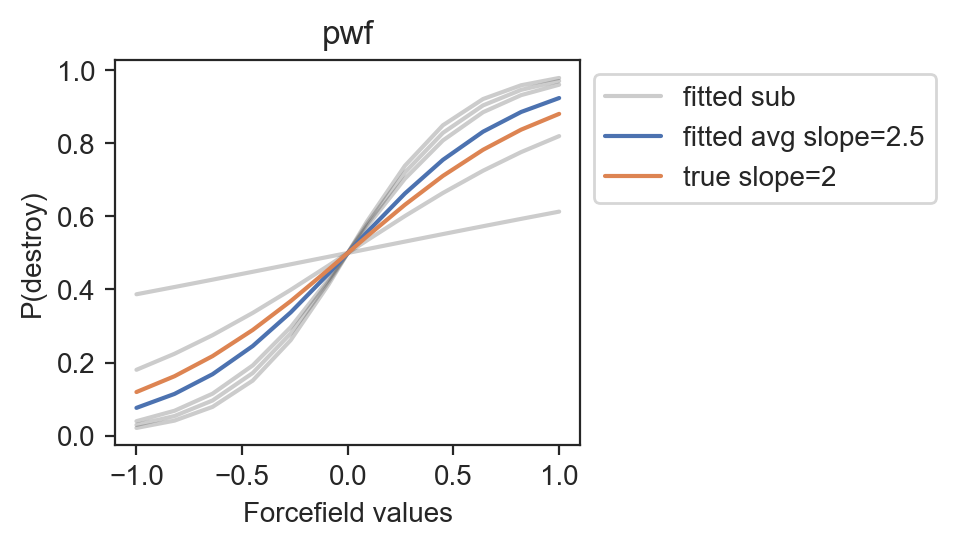

In [12]:
# display function with slope = mean(xopt)
import matplotlib.pyplot as plt

logistic = lambda slope, x: 1/(1+np.exp(-slope*x))
x = np.linspace(-1, 1, 12).round(2)
slope = np.mean(list(xopt.values())).round(2)
# slope = xopt['5610c4ea7ffc8a0005811504']

sns.set({'figure.figsize': (3, 2.5), 'figure.dpi': 200})
sns.set_style('ticks')

ax = plt.gca()
for agent, value in xopt.items():
    ax.plot(x, logistic(value, x), alpha=.2, color='black', label='fitted sub')
ax.plot(x, logistic(slope, x), label=f'fitted avg slope={slope}', color='C0')
# plot true slope = 2
ax.plot(x, logistic(2, x), label='true slope=2', color='C1')
ax.set_xlabel('Forcefield values')
ax.set_ylabel('P(destroy)')
ax.set_title('pwf')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# keep only last three for legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-3:], labels[-3:], loc='upper left', bbox_to_anchor=(1, 1))
# loc of legend outside plot
print(xopt)

(0.0, 1.0)

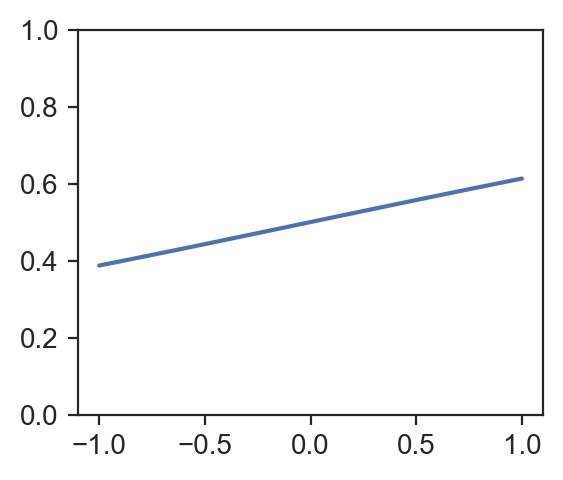

In [16]:
df['slope'] = df.agent.map(xopt)

df.filter(['agent', 'correct', 'slope']).groupby('agent').mean()

slope = .46
logistic = lambda x: 1/(1+np.exp(-slope*x))

x = np.linspace(-1, 1, 9).round(2)

plt.plot(x, logistic(x))
plt.ylim(0, 1)

In [14]:
import scipy.optimize as opt
# i have probabilities (y)
# i need to find the x values that correspond to these probabilities
# i.e. the x values that give me the y values through the logistic function
# and find the slope that minimizes the difference between the x values and the forcefield values

x = np.unique([df.ff1.values, df.ff2.values])
y = np.unique([df.p1.values, df.p2.values])

def f(slope, x, y):
    return np.sum(np.abs(logistic(slope, x) - y))
    
opt.minimize(f, 0, args=(x, y))


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.01120414741166574
        x: [ 1.992e+00]
      nit: 5
      jac: [ 2.373e-02]
 hess_inv: [[ 3.238e-03]]
     nfev: 166
     njev: 77

In [ ]:
d[d.agent=='5dd31760fb7d41000c6610e3']

,agent,model,param,value,params
6,5dd31760fb7d41000c6610e3,NormativeLogRatio,rl_temp,0.0,"{'β': 1.9894877142617042, '$\delta$': [-8.8743..."
7,5dd31760fb7d41000c6610e3,NormativeLogRatio,perceptual_temp,0.0,"{'β': 1.9894877142617042, '$\delta$': [-8.8743..."


c:\Python312\Lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Python312\Lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Python312\Lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Python312\Lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='param', ylabel='value'>

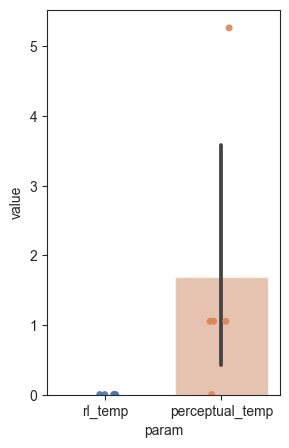

In [ ]:
sns.set({'figure.figsize': (3, 5)})
sns.set_style('ticks')
sns.barplot(x='param', y='value', data=d, alpha=.5)
sns.stripplot(x='param', y='value', data=d,alpha=.9, edgecolor='black')

IndexError: index -1 is out of bounds for axis 0 with size 0

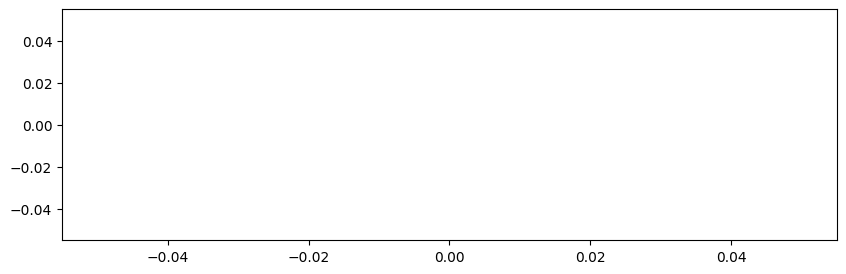

In [ ]:
#plot heatmap of liklihood (fn) for each parameter value (space)
dd = d[d.model=='NormativeEV']
plt.figure(figsize=(10, 3), dpi=100)
sns.lineplot(x='space', y='fn', data=dd, n_boot=0)
plt.ylabel('log likelihood')
plt.xlabel('$\\beta$')
plt.xticks(space)

# plt.xticks(space)


array([1.05263158, 8.42105263])

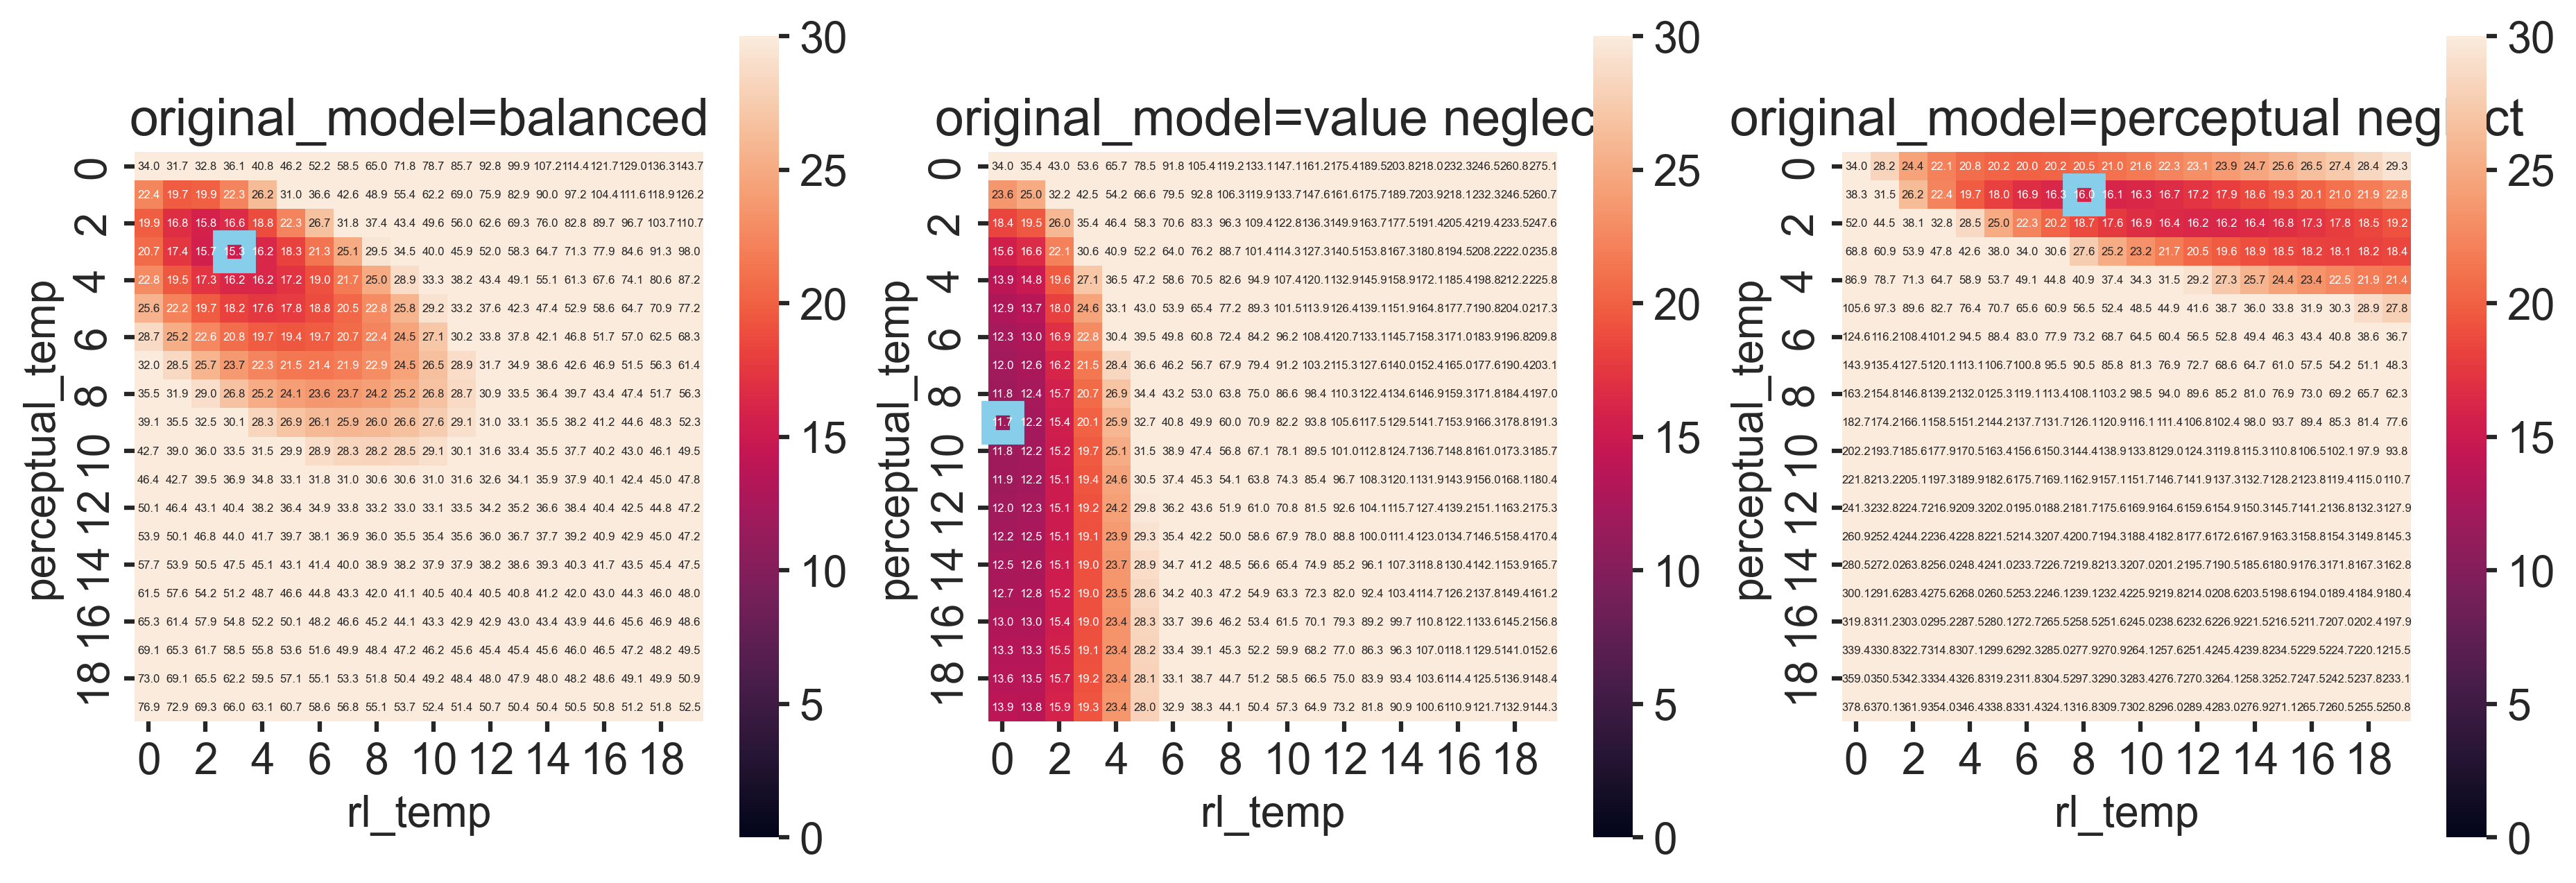

In [ ]:
# plot heatmap of liklihood (fn) for each parameter value (space)
dd = d[(d.model=='NormativeLogRatio') & (d.original_model!='random')]
plt.figure(figsize=(15, 5), dpi=300)
count = 0
for model in dd.original_model.unique():
    count += 1
    ddd = dd[dd.original_model==model].pivot(index='perceptual_temp', columns='rl_temp', values='fn')
    # change index and columns to int
    ddd.columns = ddd.columns.astype(int)
    ddd.index = ddd.index.astype(int)
    # xy = ddd.space.values
    # stack xy as a 2d array
    # xy = np.vstack(xy)
    # z = ddd.fn.values

    # plot heatmap
    plt.subplot(1, len(dd.original_model.unique()), count)
    # rs = len(space)
    
    plt.title(f'original_model={model}')
    ax = sns.heatmap(ddd,square=True, annot=True, annot_kws={"size": 4}, fmt='.1f', vmax=30, vmin=0)
    d_ = np.asarray(ddd)
    y,x = np.unravel_index(d_.argmin(), d_.shape)
    ax.add_patch(plt.Rectangle((x, y), 1, 1, fc='none', ec='skyblue', lw=5, clip_on=False))


space_all[np.argmin(ddd)]

In [ ]:
# manual fit
# -----------------------------------------------------------------
# parameters to tune
import itertools

pbar = tqdm(total=len(df.agent.unique()))
space = np.concatenate([np.linspace(0, 10, 10), np.linspace(10, 50, 5)]).flatten().round(1)
print(space)
space_all = np.array(list(itertools.product(space, repeat=2)))

# import pyfmincon.opt
# pyfmincon.opt.connect()
d = []

for agent in df.agent.unique():

    df2 = df[(df.agent==agent)]
    s, a, r = df2.s.values, df2.a.values, df2.r.values
    ff1, ff2 = df2.ff1.values, df2.ff2.values
    destroy = df2.destroy.values
    ntrials = int(df2.trial.max())

    xopt, fopt = minimize(
        f=fit,
        args=(ntrials, s, a, r, destroy, ff1, ff2), nparam=1, space=space)
    
    d.append({
            'agent': agent,
            'model': 'NormativeEV',
            'original_model': df2['model'].values[0],
            'll': fopt,
            'fitted_temp': float(xopt),
            'temp': df2['temp'].values[0],
    })

    xopt, fopt = minimize(
        f=fit,
        args=(ntrials, s, a, r, destroy, ff1, ff2), nparam=2, space=space_all)
    # print(res)
    d.append({
        'agent' : agent,
        'model': 'NormativeLogRatio',
        'original_model': df2['model'].values[0],
        'll': fopt,
        'fitted_rl_temp': xopt[1],
        'fitted_perceptual_temp': xopt[0],
        'rl_temp': df2['rl_temp'].values[0],
        'perceptual_temp': df2['perceptual_temp'].values[0],
    })

    pbar.update()

pbar.refresh()

d = pd.DataFrame(d)


  0%|          | 0/50 [00:00<?, ?it/s]

[ 0.   1.1  2.2  3.3  4.4  5.6  6.7  7.8  8.9 10.  10.  20.  30.  40.
 50. ]


C:\Users\basil\AppData\Local\Temp\ipykernel_10288\3873129865.py:24: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  ff_chosen = [ff1[t], ff2[t]][a[t]]
C:\Users\basil\AppData\Local\Temp\ipykernel_10288\3874629961.py:287: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  if p[a] == 0:
C:\Users\basil\AppData\Local\Temp\ipykernel_10288\3874629961.py:289: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return p[a]
C:\Users\basil\AppData\Local\Temp\ipykernel_10288\3874629961.py:326: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  if p[a] == 0:
C:\Users\basil\AppData\Local\Temp\ipykernel_10288\3874629961.py:329: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return p[a]
C:\Users\basil\AppData\Local\Temp\ipyke

In [ ]:
# parameter retrieval
import scipy.optimize as opt
# import fit


models = (NormativeLogRatio, )
pbar = tqdm(total=len(df.agent.unique()))
method = 'scipy'
ub = [100]
lb = [.001]
x0 = np.mean([ub, lb], axis=0).tolist()

import pyfmincon.opt
pyfmincon.opt.connect()
d = []


for agent in df.agent.unique():

    df2 = df[(df.agent==agent)]
    s, a, r = df2.s.values, df2.a.values, df2.r.values
    ff1, ff2 = df2.ff1.values, df2.ff2.values
    destroy = df2.destroy.values
    ntrials = int(df2.trial.max())

    # if method == 'matlab':
    #     x = pyfmincon.opt.fmincon(
    #             function='fit.fit',
    #             x0=x0,
    #             optional_args=[ntrials, s, a.astype(int), r, destroy.astype(int), ff1, ff2],
    #             lb=lb,
    #             ub=ub,
    #             options={}
    #     )
    #     xopt = x[0]
    #     fopt = x[1]


    # if method == 'scipy':
    #     res = opt.minimize(
    #         fit,
    #         x0,
    #         args=(ntrials, s, a, r, destroy, ff1, ff2), method='L-BFGS-B',
    #         bounds=[(0, 10)])
    #     # xopt, fopt = matlab.fmincon(
    #     xopt = res.x[0]
    #     fopt = res.fun

    # d.append({
    #     'agent': agent,
    #     'model': 'NormativeEV',
    #     'original_model': df2['model'].values[0],
    #     'll': fopt,
    #     'fitted_temp': float(xopt),
    #     'temp': df2['temp'].values[0],
    # })

    if method == 'matlab':
        x = pyfmincon.opt.fmincon(
                function='fit.fit2',
                x0=x0 * 2,
                # optional_args=[ntrials, s, a.astype(int), r, destroy.astype(int), ff1, ff2],
                optional_args=[ntrials, s],
                lb=lb * 2,
                ub=ub * 2,
                options={}
        )
        xopt = x[0]
        fopt = x[1]

    if method == 'scipy':
        res = opt.minimize(
            fit,
            x0 * 2,
            args=(ntrials, s, a, r, destroy, ff1, ff2), method='L-BFGS-B',
            bounds=[(0, 30), (0, 30)], options=dict(ftol=1e-8))
        
        xopt = res.x
        fopt = res.fun

    # print(res)
    d.append({
        'agent' : agent,
        'model': 'NormativeLogRatio',
        'original_model': df2['model'].values[0],
        'll': fopt,
        'fitted_rl_temp': xopt[1],
        'fitted_perceptual_temp': xopt[0],
        'rl_temp': df2['rl_temp'].values[0],
        'perceptual_temp': df2['perceptual_temp'].values[0],
    })

    pbar.update()

pbar.refresh()

d = pd.DataFrame(d)
d.to_csv('data/fit.csv', index=False)

  0%|          | 0/400 [00:00<?, ?it/s]

             T  dof alternative     p-val          CI95%   cohen-d     BF10  \
T-test -4.5985   58   two-sided  0.000024  [-11.7, -4.6]  1.187328  788.479   

           power  
T-test  0.994784  
               T  dof alternative         p-val          CI95%   cohen-d  \
T-test  5.637197   58   two-sided  5.358005e-07  [7.14, 14.99]  1.455518   

             BF10     power  
T-test  2.355e+04  0.999829  


SyntaxError: 'return' outside function (3859054300.py, line 96)

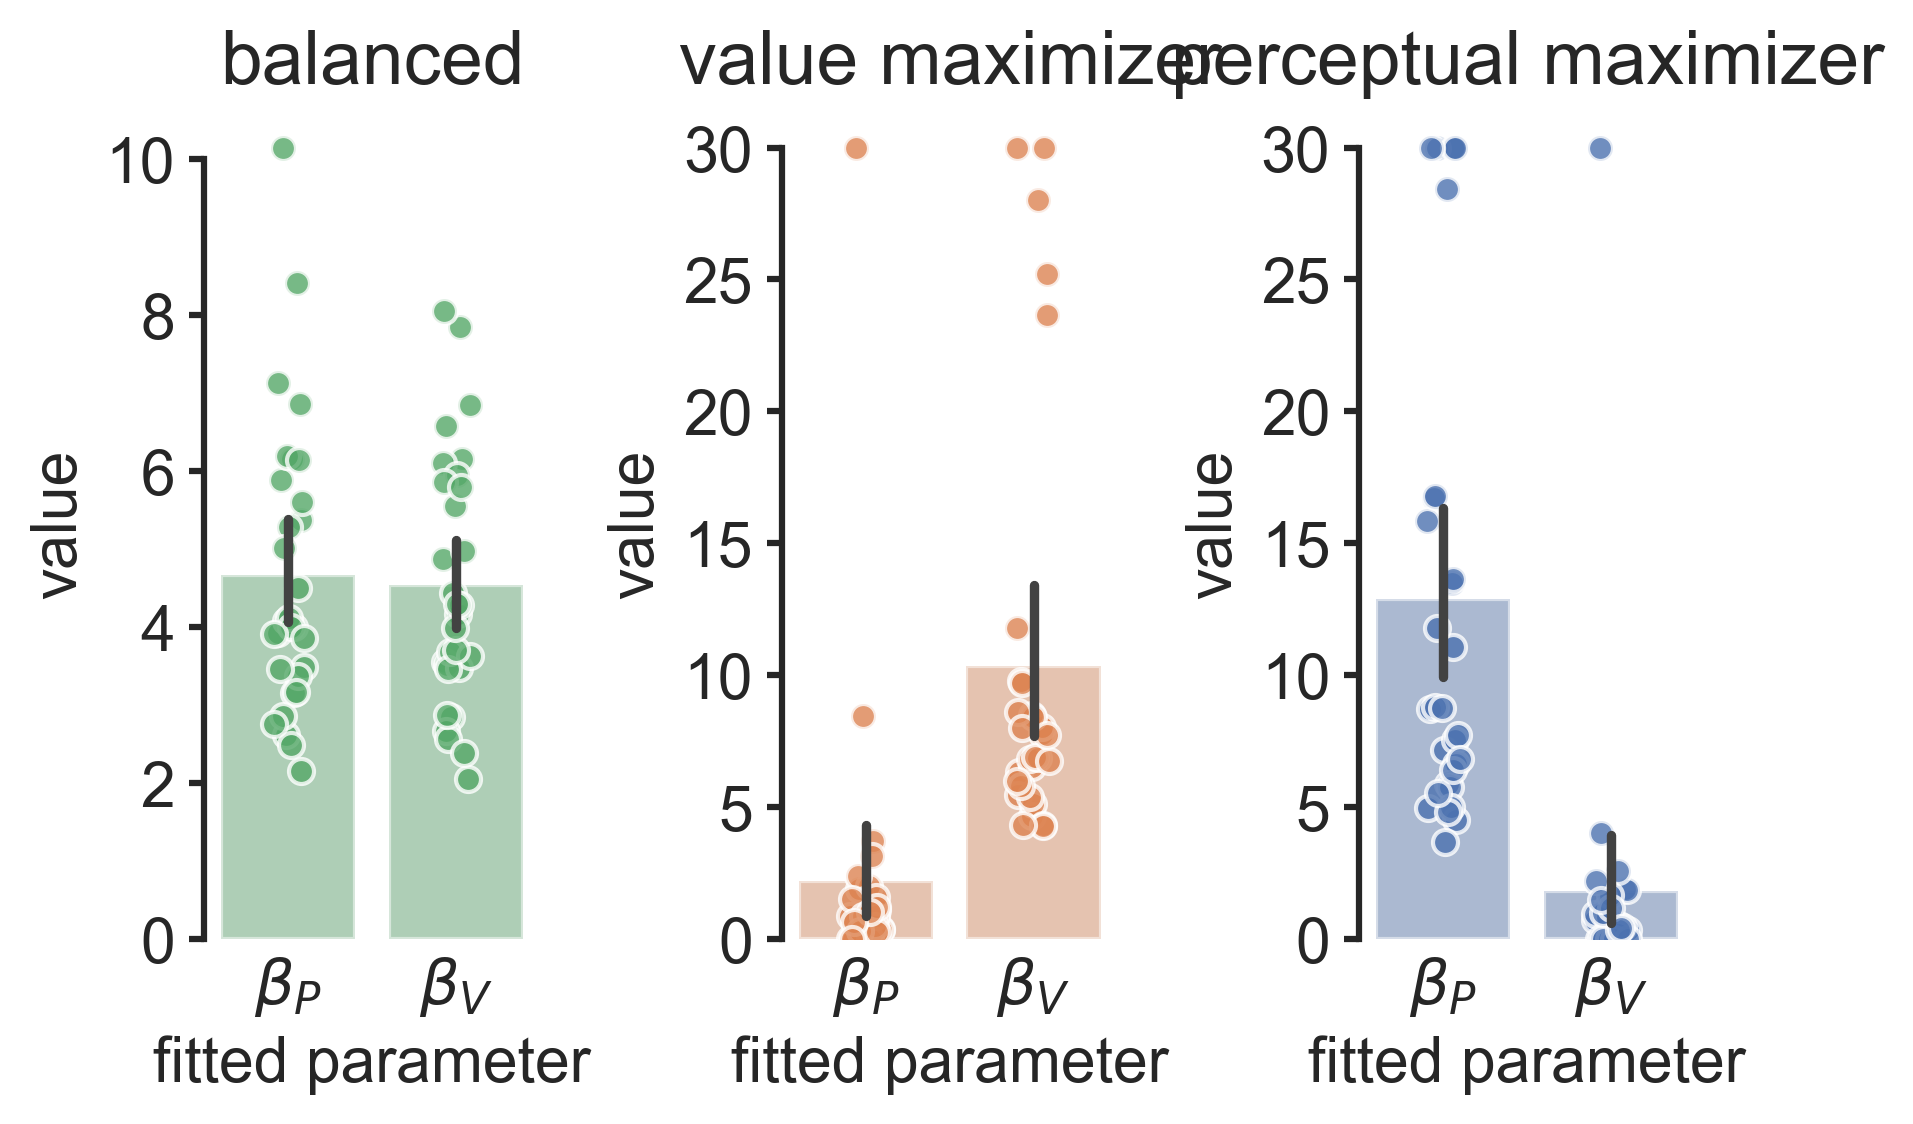

In [ ]:
# select 30 perceptual neglect
d = pd.read_csv('data/fit.csv')
np.random.seed(1)
n = 30
d1 = d[(d.model=='NormativeLogRatio') & (d.original_model=='perceptual neglect')].sample(n=n)
assert len(d1.agent.unique()) == n
d2 = d[(d.model=='NormativeLogRatio') & (d.original_model=='value neglect')].sample(n=n)
assert len(d2.agent.unique()) == n
d3 = d[(d.model=='NormativeLogRatio') & (d.original_model=='balanced')].sample(n=n)
assert len(d3.agent.unique()) == n
d4 = d[(d.model=='NormativeLogRatio') & (d.original_model=='random')].sample(n=n)
assert len(d3.agent.unique()) == n



models = [d1, d2, d3, d4]

# d_full = pd.DataFrame()
# d_full['parameter'] = ['perceptual_temp', ] * n
# d_full['value'] = d1.
d_full = pd.concat(models)
length = len(d_full)
dfull = pd.DataFrame()
dfull['parameter'] = ['$\\beta_P$', ] * length + ['$\\beta_V$', ] * length
dfull['value'] = d_full['fitted_perceptual_temp'].tolist() + d_full['fitted_rl_temp'].tolist()
dfull['model'] = d_full['original_model'].tolist() * 2

# remove outliers using stats zscore
from scipy import stats
dfull['z'] = np.abs(stats.zscore(dfull['value']))
# dfull = dfull[dfull.z < 3]


plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 300
# increase axes width
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
# increase font size
plt.rcParams.update({'font.size': 15})
sns.set_palette('deep')
palette = ['C2', 'C0', 'C1', 'grey']
sns.set_palette(palette=palette)

dfull1 = dfull[dfull.model=='balanced']
plt.subplot(1, 3, 1)
sns.barplot(x='parameter', y='value', data=dfull1, zorder=0, color='C0', alpha=.5)
sns.stripplot(x='parameter', y='value', data=dfull1,alpha=.8, edgecolor='w', linewidth=1, size=6, zorder=0, color='C0')
plt.ylabel('value')
plt.xlabel('fitted parameter')
plt.title('balanced')
sns.despine(trim=True, bottom=True)
plt.tick_params(axis='x', length=0)

dfull2 = dfull[dfull.model=='value neglect']
plt.subplot(1, 3, 3)
sns.barplot(x='parameter', y='value', data=dfull2, zorder=0, color='C1', alpha=.5)
sns.stripplot(x='parameter', y='value', data=dfull2,alpha=.8, edgecolor='w', linewidth=1, size=6, zorder=0, color='C1')
plt.ylabel('value')
plt.xlabel('fitted parameter')
plt.title('perceptual maximizer')
sns.despine(trim=True, bottom=True)
plt.tick_params(axis='x', length=0)


dfull3 = dfull[dfull.model=='perceptual neglect']
plt.subplot(1, 3, 2)
sns.barplot(x='parameter', y='value', data=dfull3, zorder=0, color='C2', alpha=.5)
sns.stripplot(x='parameter', y='value', data=dfull3,alpha=.8, edgecolor='w', linewidth=1, size=6, zorder=0, color='C2')
plt.ylabel('value')
plt.xlabel('fitted parameter')
plt.title('value maximizer')
sns.despine(trim=True, bottom=True)
plt.tick_params(axis='x', length=0)



plt.tight_layout()	
# plt.tick_params(axis='x', labelsize=8.5)
x1 = d_full[d_full.original_model=='perceptual neglect'].fitted_perceptual_temp
y1 = d_full[d_full.original_model=='value neglect'].fitted_perceptual_temp

x2 = d_full[d_full.original_model=='perceptual neglect'].fitted_rl_temp
y2 = d_full[d_full.original_model=='value neglect'].fitted_rl_temp

import pingouin as pg
print(pg.ttest(x1, x2))
print(pg.ttest(y1, y2))

plt.savefig('figs/result2.svg')

return

plt.subplot(1, 2, 2)
sns.barplot(x='original_model', y='fitted_rl_temp', data=dfull, alpha=.5, zorder=0, palette=['C2', 'C1'])
sns.stripplot(x='original_model', y='fitted_rl_temp', data=dfull, color='C0', alpha=.8, edgecolor='w', linewidth=1, size=6, zorder=0, palette=['C2', 'C1'])
plt.ylabel('fitted $\\beta_V$')
plt.tick_params(axis='x', labelsize=8.5)
plt.tight_layout()


return
# add a column 
from scipy import stats
 
# dfull['z'] = np.abs(stats.zscore(dfull['fitted_perceptual_temp']))
# dfull = dfull[dfull.z < 2]
# dfull['z'] = np.abs(stats.zscore(dfull['fitted_rl_temp']))
# dfull = dfull[dfull.z < 2]

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 300
plt.subplot(1, 2, 1)
sns.barplot(x='original_model', y='fitted_perceptual_temp', data=dfull, zorder=0, palette=['C2', 'C1'])
sns.stripplot(x='original_model', y='fitted_perceptual_temp', data=dfull, color='C0', alpha=.8, edgecolor='w', linewidth=1, size=6, zorder=0, palette=['C2', 'C1'])
plt.ylabel('fitted $\\beta_P$')
plt.tick_params(axis='x', labelsize=8.5)


plt.subplot(1, 2, 2)
sns.barplot(x='original_model', y='fitted_rl_temp', data=dfull, alpha=.5, zorder=0, palette=['C2', 'C1'])
sns.stripplot(x='original_model', y='fitted_rl_temp', data=dfull, color='C0', alpha=.8, edgecolor='w', linewidth=1, size=6, zorder=0, palette=['C2', 'C1'])
plt.ylabel('fitted $\\beta_V$')
plt.tick_params(axis='x', labelsize=8.5)
plt.tight_layout()


x1 = dfull[dfull.original_model=='perceptual neglect'].fitted_perceptual_temp
y1 = dfull[dfull.original_model=='value neglect'].fitted_perceptual_temp

x2 = dfull[dfull.original_model=='perceptual neglect'].fitted_rl_temp
y2 = dfull[dfull.original_model=='value neglect'].fitted_rl_temp

import pingouin as pg
pg.ttest(x1, y1)


In [ ]:
dfull.fitted_perceptual_temp

322    1.887418
338    0.882236
134    2.017778
326    1.093613
374    0.247885
         ...   
204    4.744387
100    3.263421
24     3.691661
52     4.277753
276    3.527123
Name: fitted_perceptual_temp, Length: 105, dtype: float64

C:\Users\garciaba\AppData\Local\Temp\ipykernel_9524\2624842447.py:11: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2.5}` instead.

  sns.barplot(x='model', y='bic', hue='original_model', data=d, alpha=.2, zorder=-1, errwidth=2.5, capsize=0)


Text(0.5, 1.0, 'Model competition')

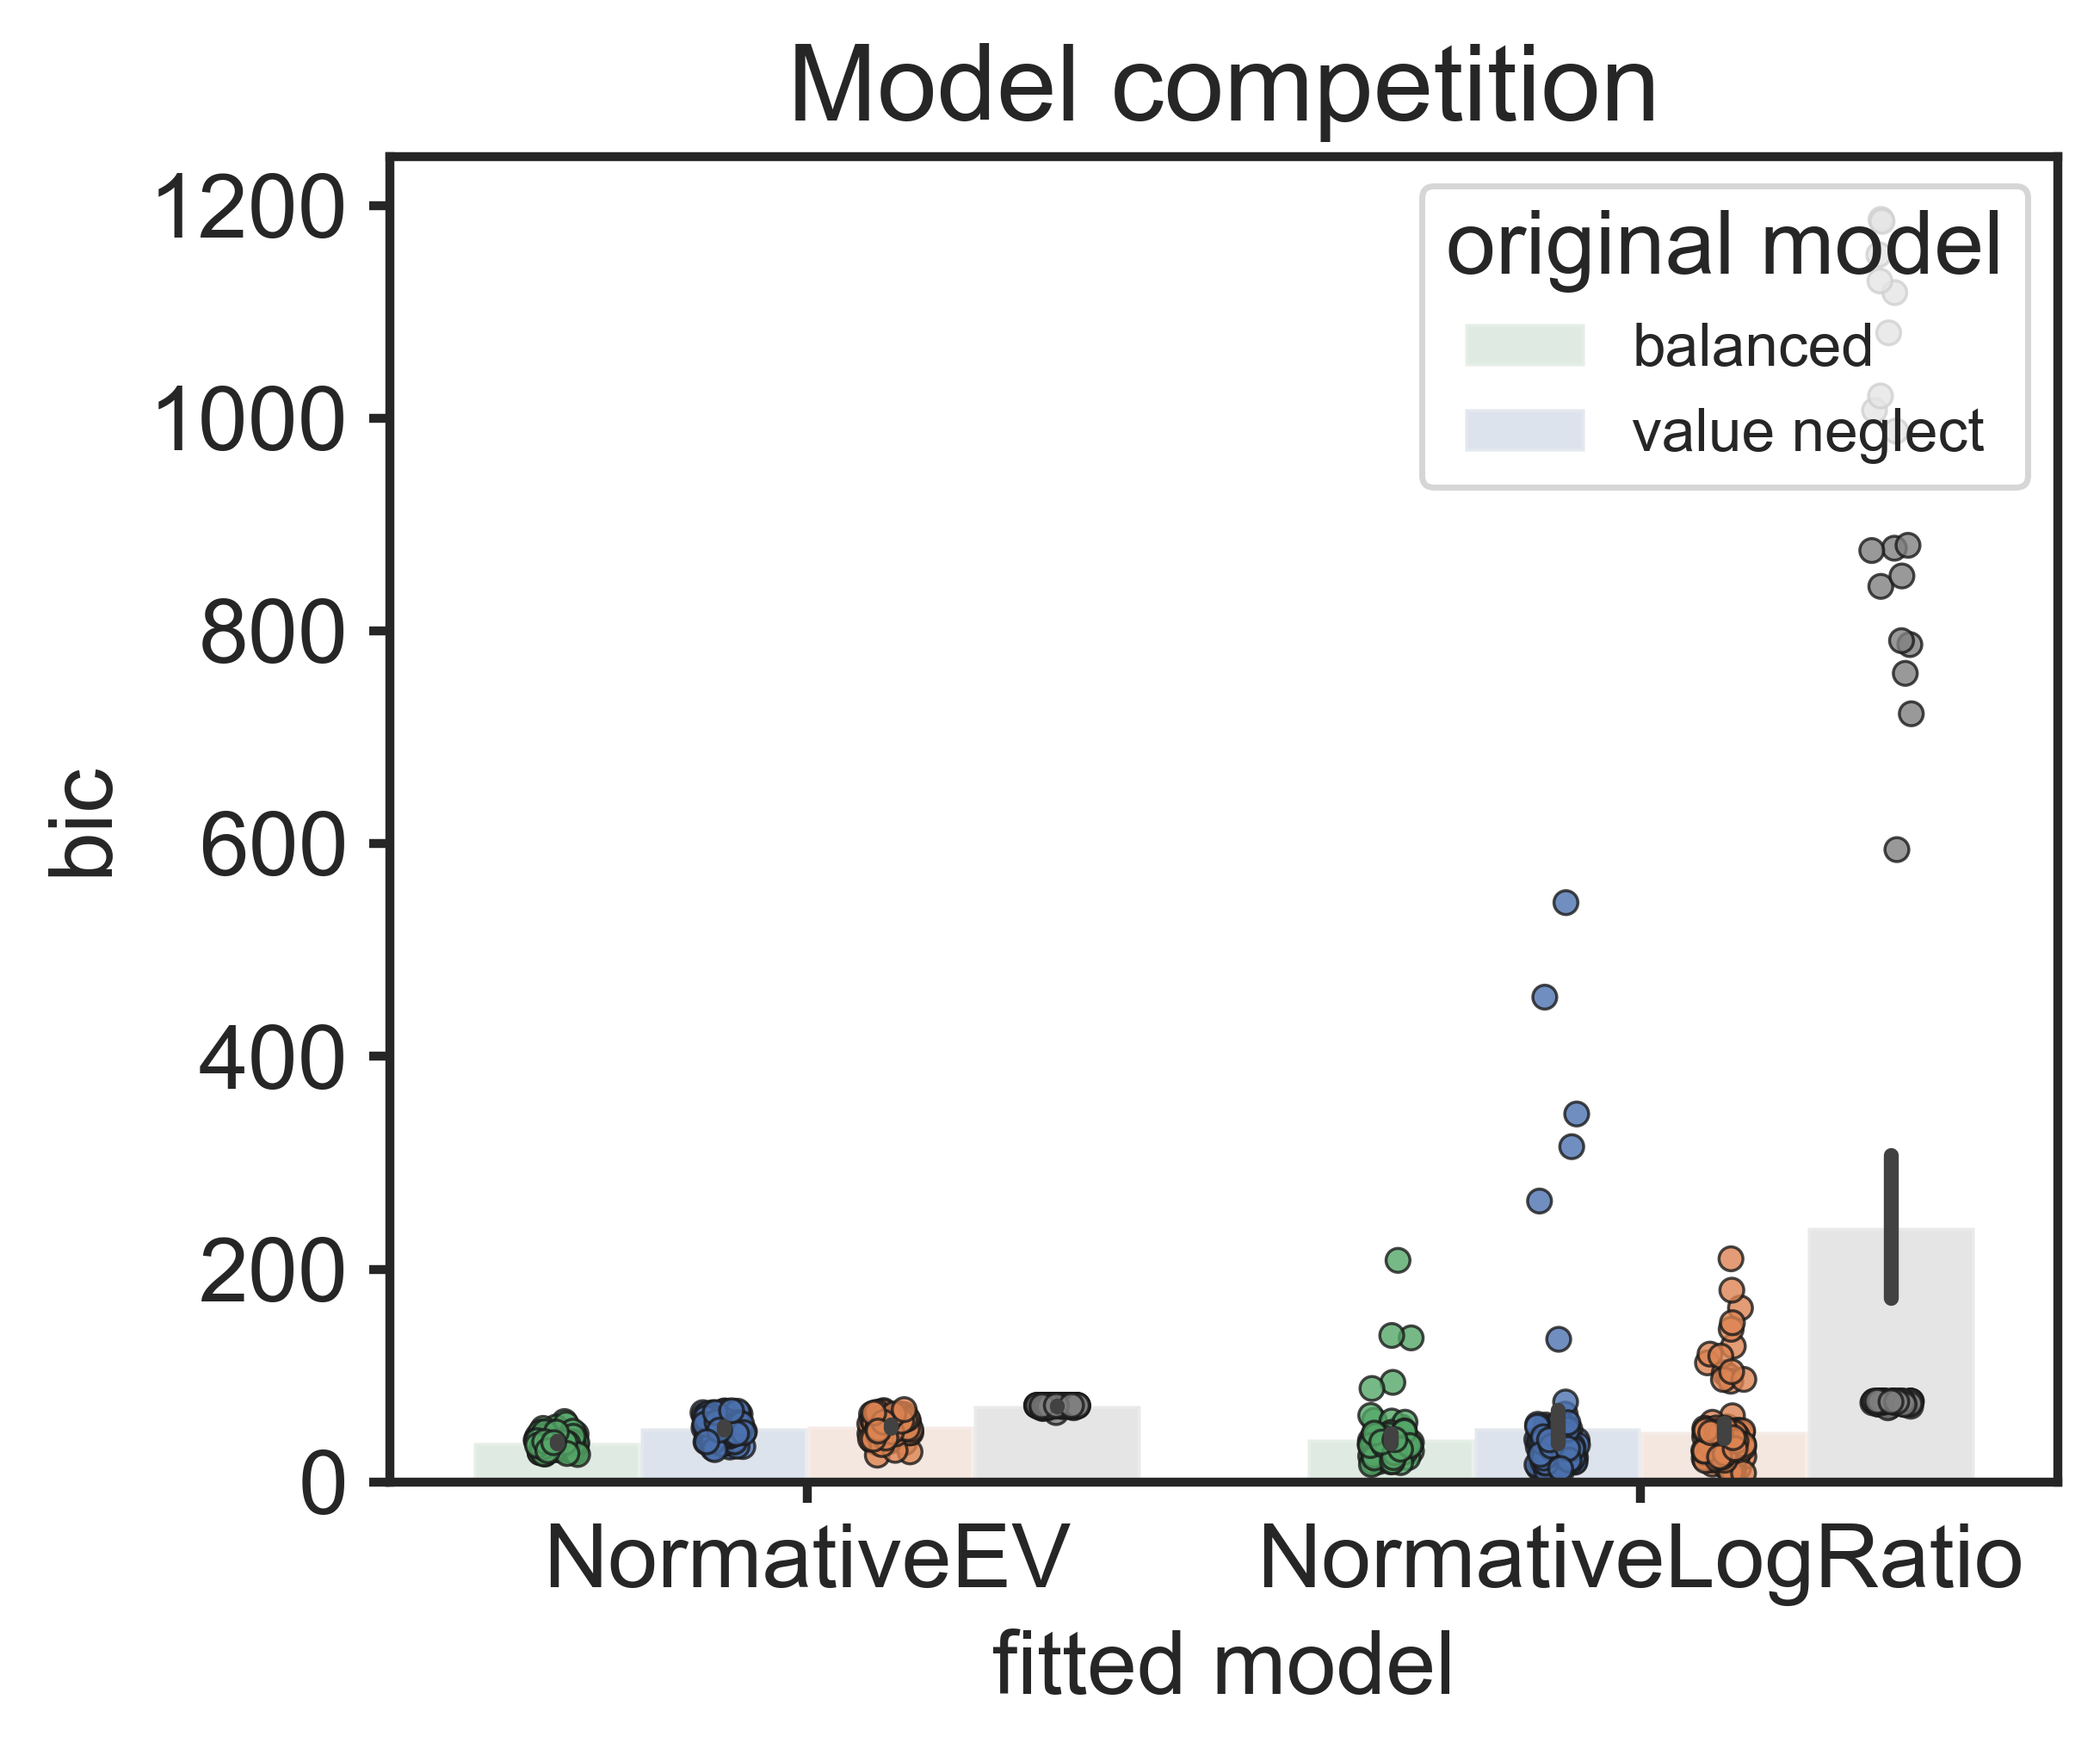

In [ ]:
# compute BIC 
d.loc[d.model=='NormativeLogRatio', 'bic'] = -2*-d[d.model=='NormativeLogRatio'].ll + np.log(ntrials)*2
d.loc[d.model=='NormativeEV', 'bic'] = -2*-d[d.model=='NormativeEV'].ll + np.log(ntrials)*1

# compute AIC
d.loc[d.model=='NormativeLogRatio', 'aic'] = -2*-d[d.model=='NormativeLogRatio'].ll + 2*2
d.loc[d.model=='NormativeEV', 'aic'] = -2*-d[d.model=='NormativeEV'].ll + 2*1

# plot BIC 
plt.figure(figsize=(5, 4), dpi=500)
sns.barplot(x='model', y='bic', hue='original_model', data=d, alpha=.2, zorder=-1, errwidth=2.5, capsize=0)

sns.stripplot(x='model', y='bic', hue='original_model', data=d, dodge=True, size=4, alpha=.8, zorder=1, linewidth=.5, edgecolor='k')
plt.xlabel('fitted model')

# Plot the legend for stripplot only
handles, labels = plt.gca().get_legend_handles_labels()
stripplot_legend = plt.legend(handles[:2], labels[:2], title='original model', loc='upper right')
plt.xlabel('fitted model')
plt.title('Model competition')

# Remove the default legend
# plt.gca().get_legend().remove()



In [ ]:
# plot fitted temp as barplot
plt.figure(figsize=(4, 5), dpi=500)
dd = d[d.model=='NormativeEV']
sns.barplot(x='original_model', y='fitted_temp', data=dd, alpha=.2, zorder=-1)
sns.stripplot(x='original_model', y='fitted_temp', data=dd, linewidth=.5, s=7,
               edgecolor='black', zorder=1, palette=['C0', 'C1'])
# plot true temp as a dot
# sns.scatterplot(x='original_model', y='temp', data=dd, color='k', s=100)
plt.ylabel('fitted temperature')
# plt.ylim(1e5, 1e7)
plt.title('NormativeEV fitted')




ValueError: Could not interpret input 'original_model'

<Figure size 2000x2500 with 0 Axes>

(20.0, 100.0)

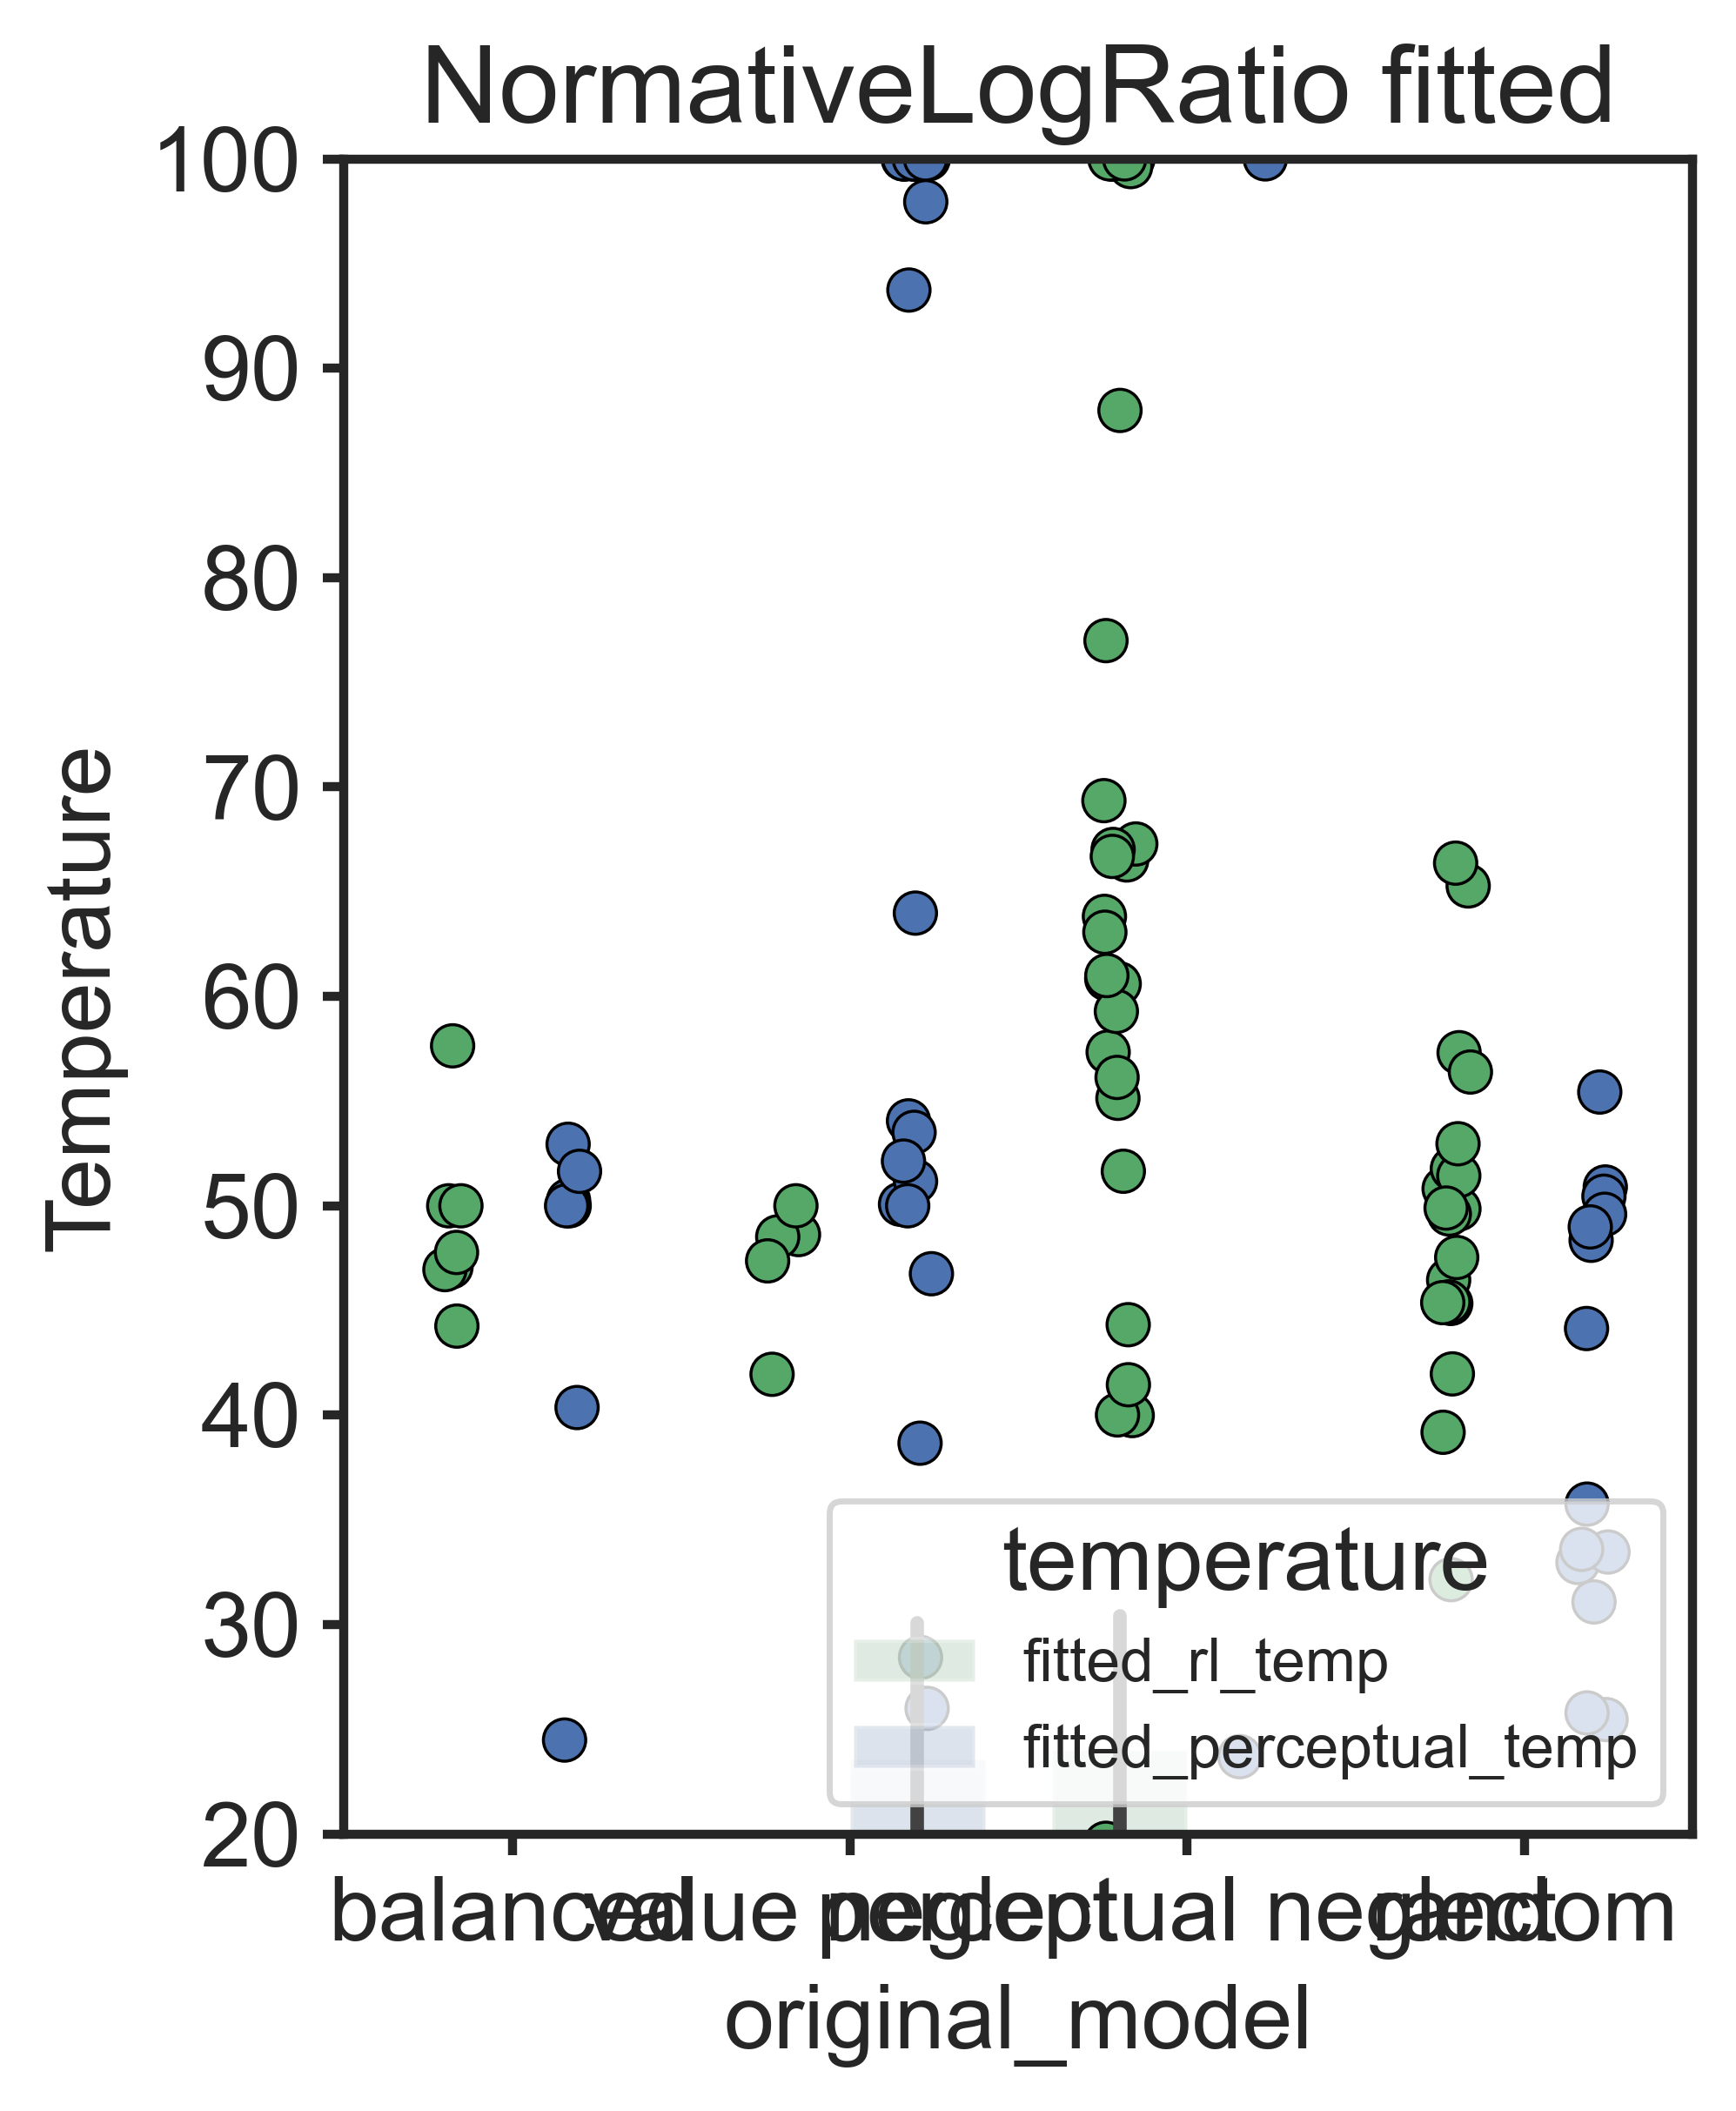

In [ ]:
plt.figure(figsize=(4, 5), dpi=500)
dd = d[d.model == 'NormativeLogRatio']

# Create a new DataFrame with the desired structure
df_combined = pd.DataFrame({
    'original_model': list(dd['original_model']) * 2,
    'variable': ['fitted_rl_temp'] * len(dd) + ['fitted_perceptual_temp'] * len(dd),
    'value': list(dd['fitted_rl_temp']) + list(dd['fitted_perceptual_temp'])
})

# Create a barplot with the new DataFrame
sns.barplot(
    x='original_model', y='value', hue='variable', data=df_combined, alpha=0.2)

# Add stripplot for additional data
sns.stripplot(
    x='original_model', y='value', hue='variable', data=df_combined, linewidth=0.5, s=7, edgecolor='black', zorder=1, dodge=True)

plt.ylabel('Temperature')
plt.title('NormativeLogRatio fitted')

# Customize the legend (optional)
# Plot the legend for stripplot only
handles, labels = plt.gca().get_legend_handles_labels()
stripplot_legend = plt.legend(handles[:2], labels[:2], title='temperature', loc='lower right')
plt.ylim([20, 100])



c:\Python312\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 6.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Python312\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 48.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


(0.0, 21.0)

c:\Python312\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 29.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


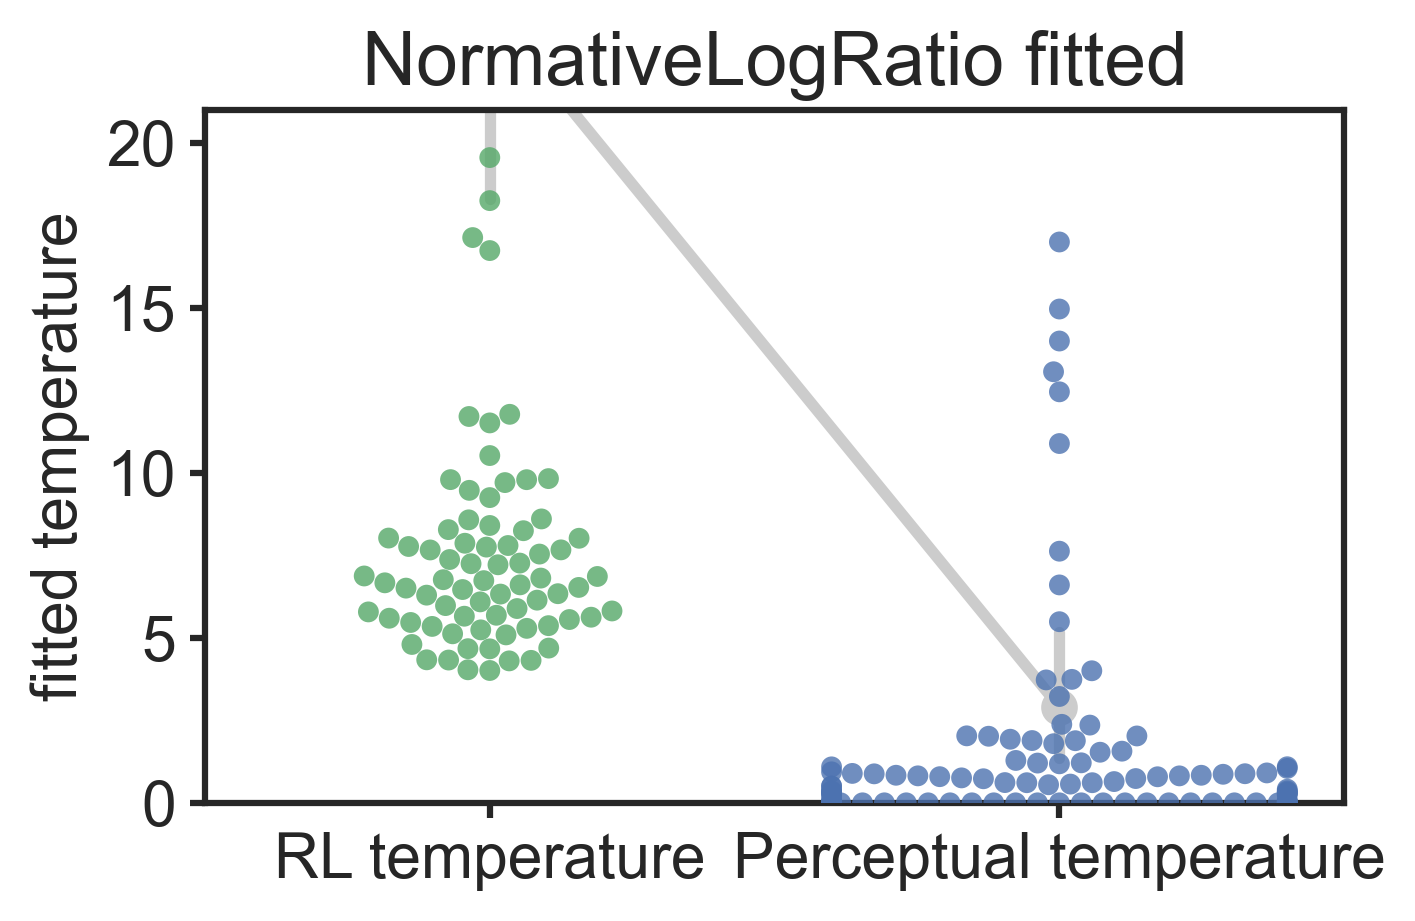

In [ ]:
# fitted rl temp and perceptual temp
plt.figure(figsize=(4.9, 3))
d3 = d[(d.model=='NormativeLogRatio') & (d.original_model=='perceptual neglect')]
# sns.barplot([d3['fitted_rl_temp'], d3['fitted_perceptual_temp']], alpha=.4)
# light grey color 
c = '#cccccc'
sns.pointplot([d3['fitted_rl_temp'], d3['fitted_perceptual_temp']], color=c)
sns.swarmplot([d3['fitted_rl_temp'], d3['fitted_perceptual_temp']], alpha=.8, zorder=2000)
# plt.ylim([5, 15])
plt.ylabel('fitted temperature')
plt.xticks([0, 1], ['RL temperature', 'Perceptual temperature'])
plt.title('NormativeLogRatio fitted')
plt.ylim([0, 21])

Text(0, 15, 'r=0.57, p=0.00')

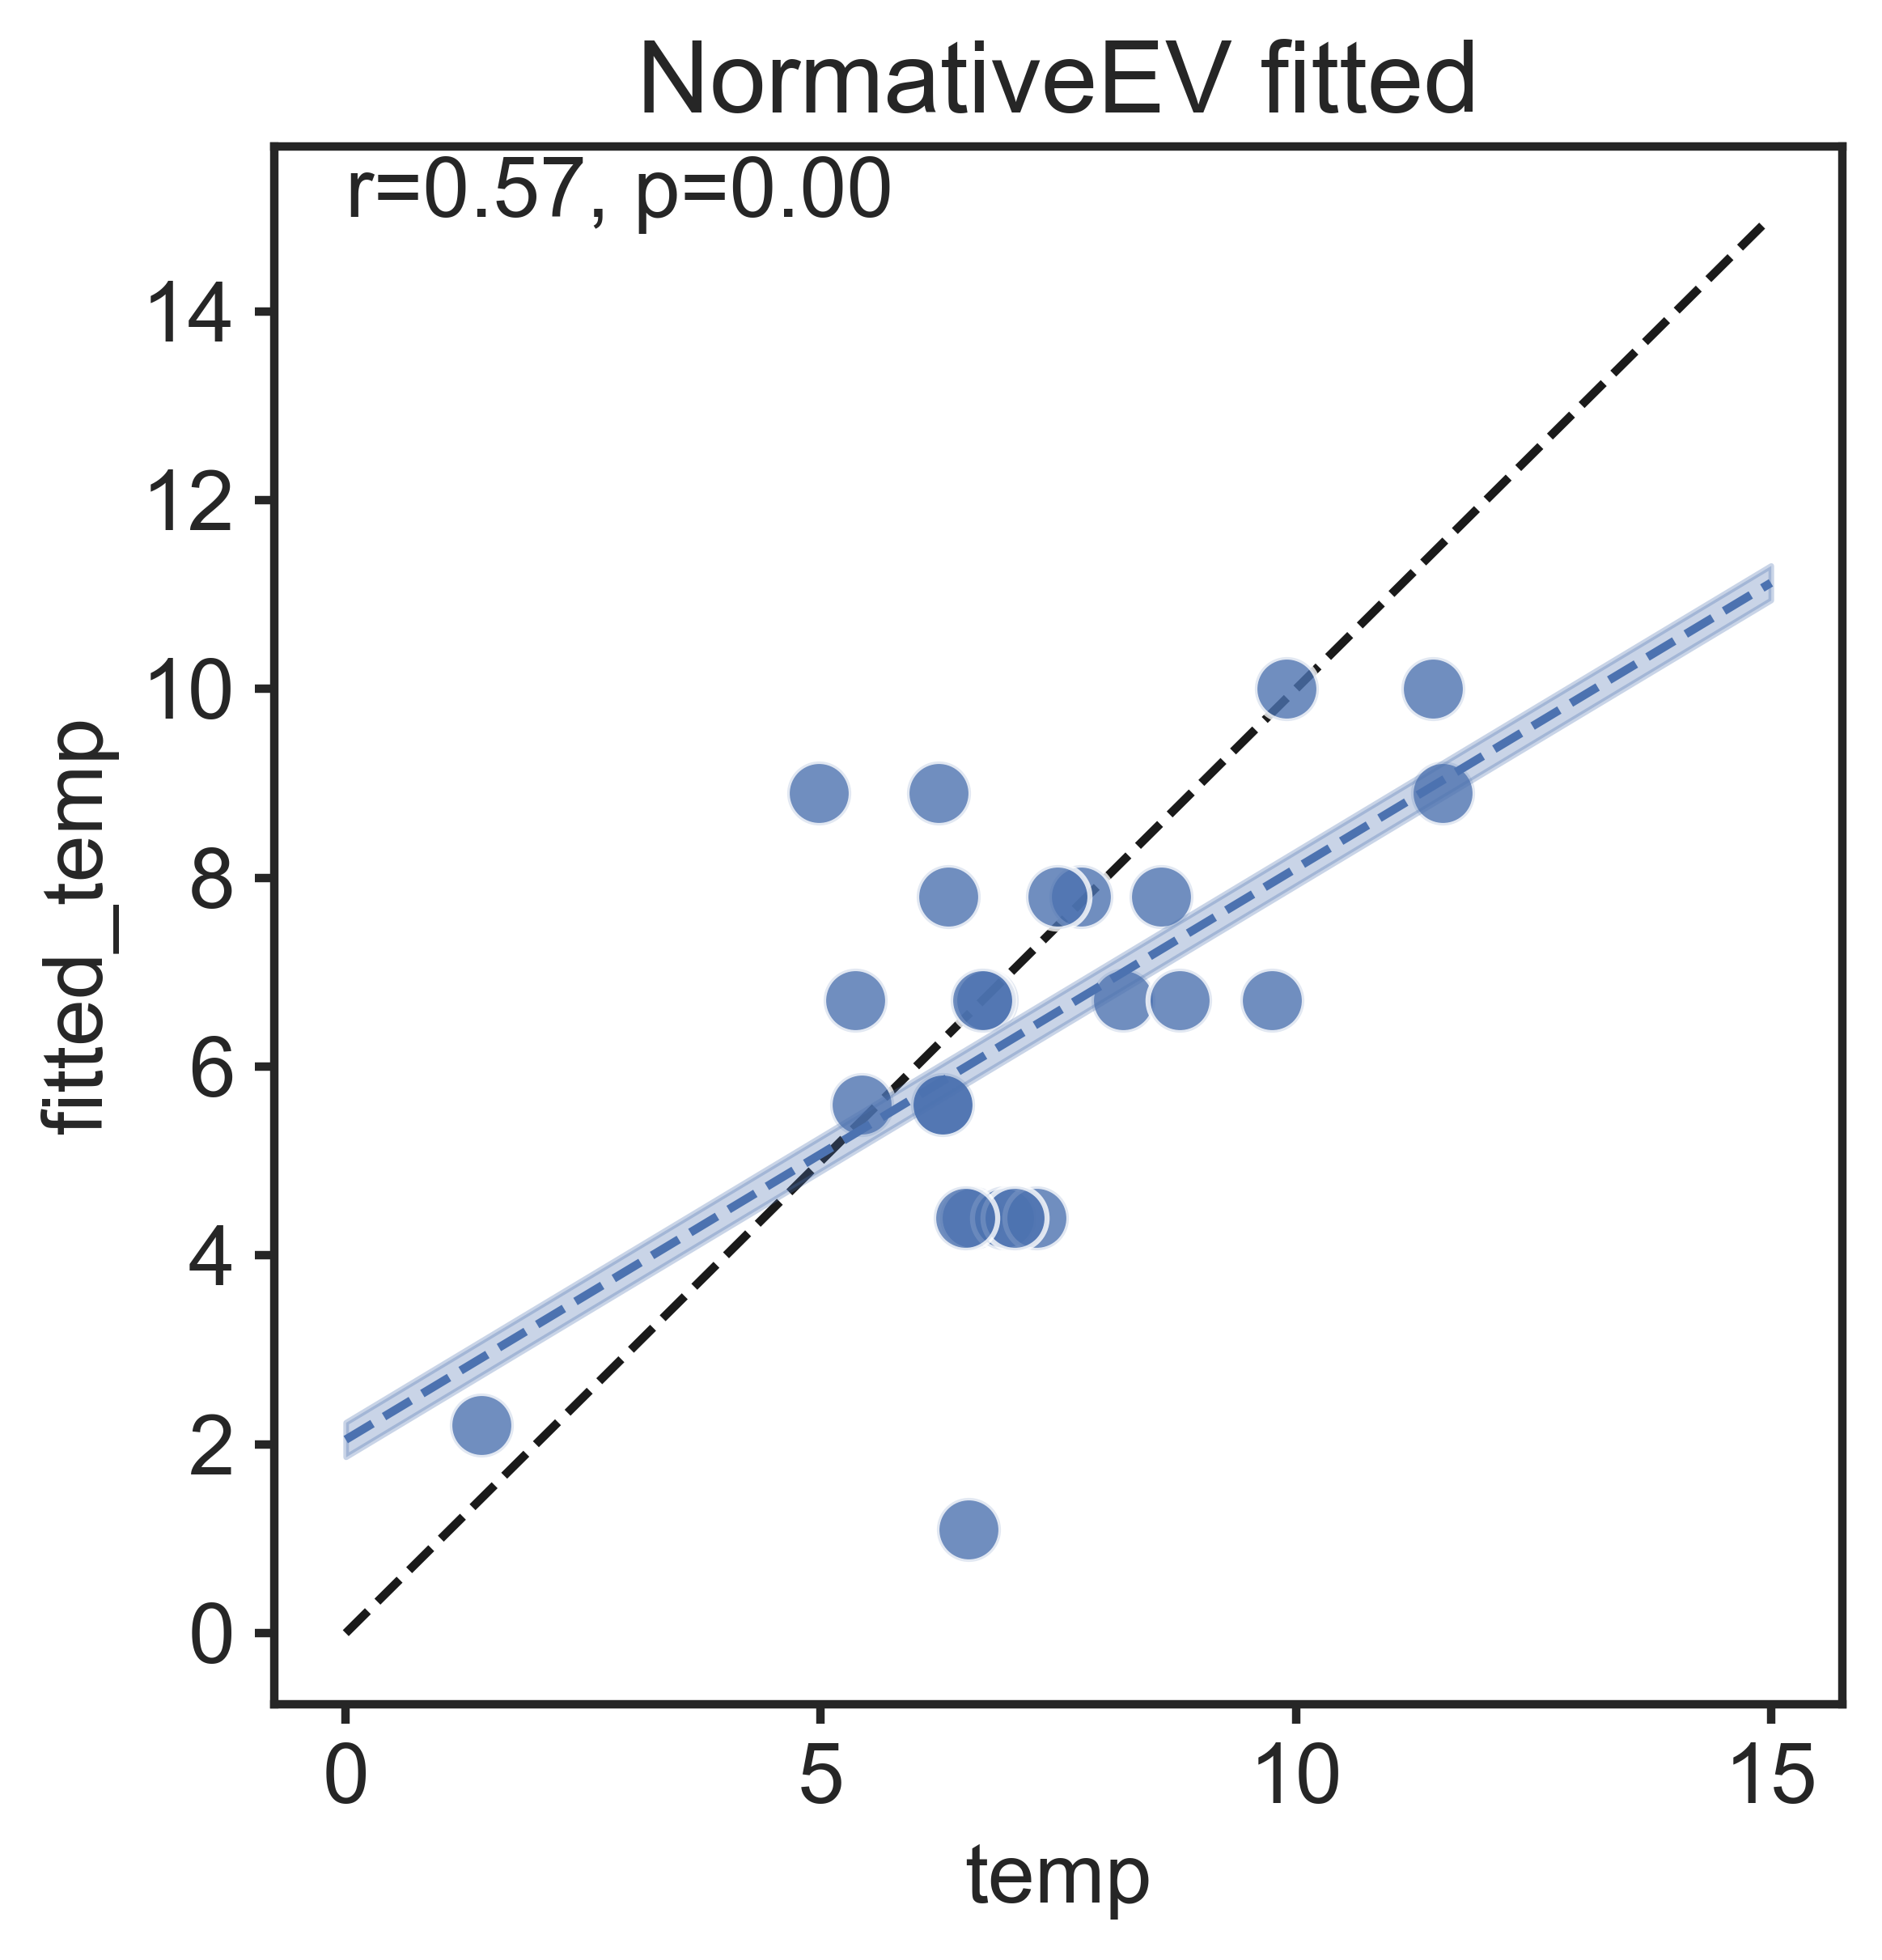

In [ ]:
# -----------------------------------------------------------------
# PLOT
# -----------------------------------------------------------------
max_ = 15
plt.figure(figsize=(5, 5), dpi=500)
d2 = d[(d.model=='NormativeEV') & (d.original_model=='NormativeEV')]
sns.scatterplot(x='temp', y='fitted_temp', data=d2, s=130, alpha=.8)
# plot identity
plt.plot([0, 15], [0, 15], color='k', linestyle='--', zorder=-1)
plt.title('NormativeEV fitted')
# return
# plot linear regression with scipy
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(d2['temp'], d2['fitted_temp'])
plt.plot([0, max_], [intercept, max_*slope+intercept], color='C0', linestyle='--')
# plot confidence interval
plt.fill_between([0, max_], [intercept-std_err, max_*slope+intercept-std_err], [intercept+std_err, max_*slope+intercept+std_err], alpha=.3, color='b')

from scipy.stats import pearsonr

r, p = pearsonr(d2['temp'].dropna(), d2['fitted_temp'].dropna())
plt.text(0, 15, f'r={r:.2f}, p={p:.2f}', fontdict={'fontsize': 15})

Text(2, 9, 'r=0.73, p=0.00')

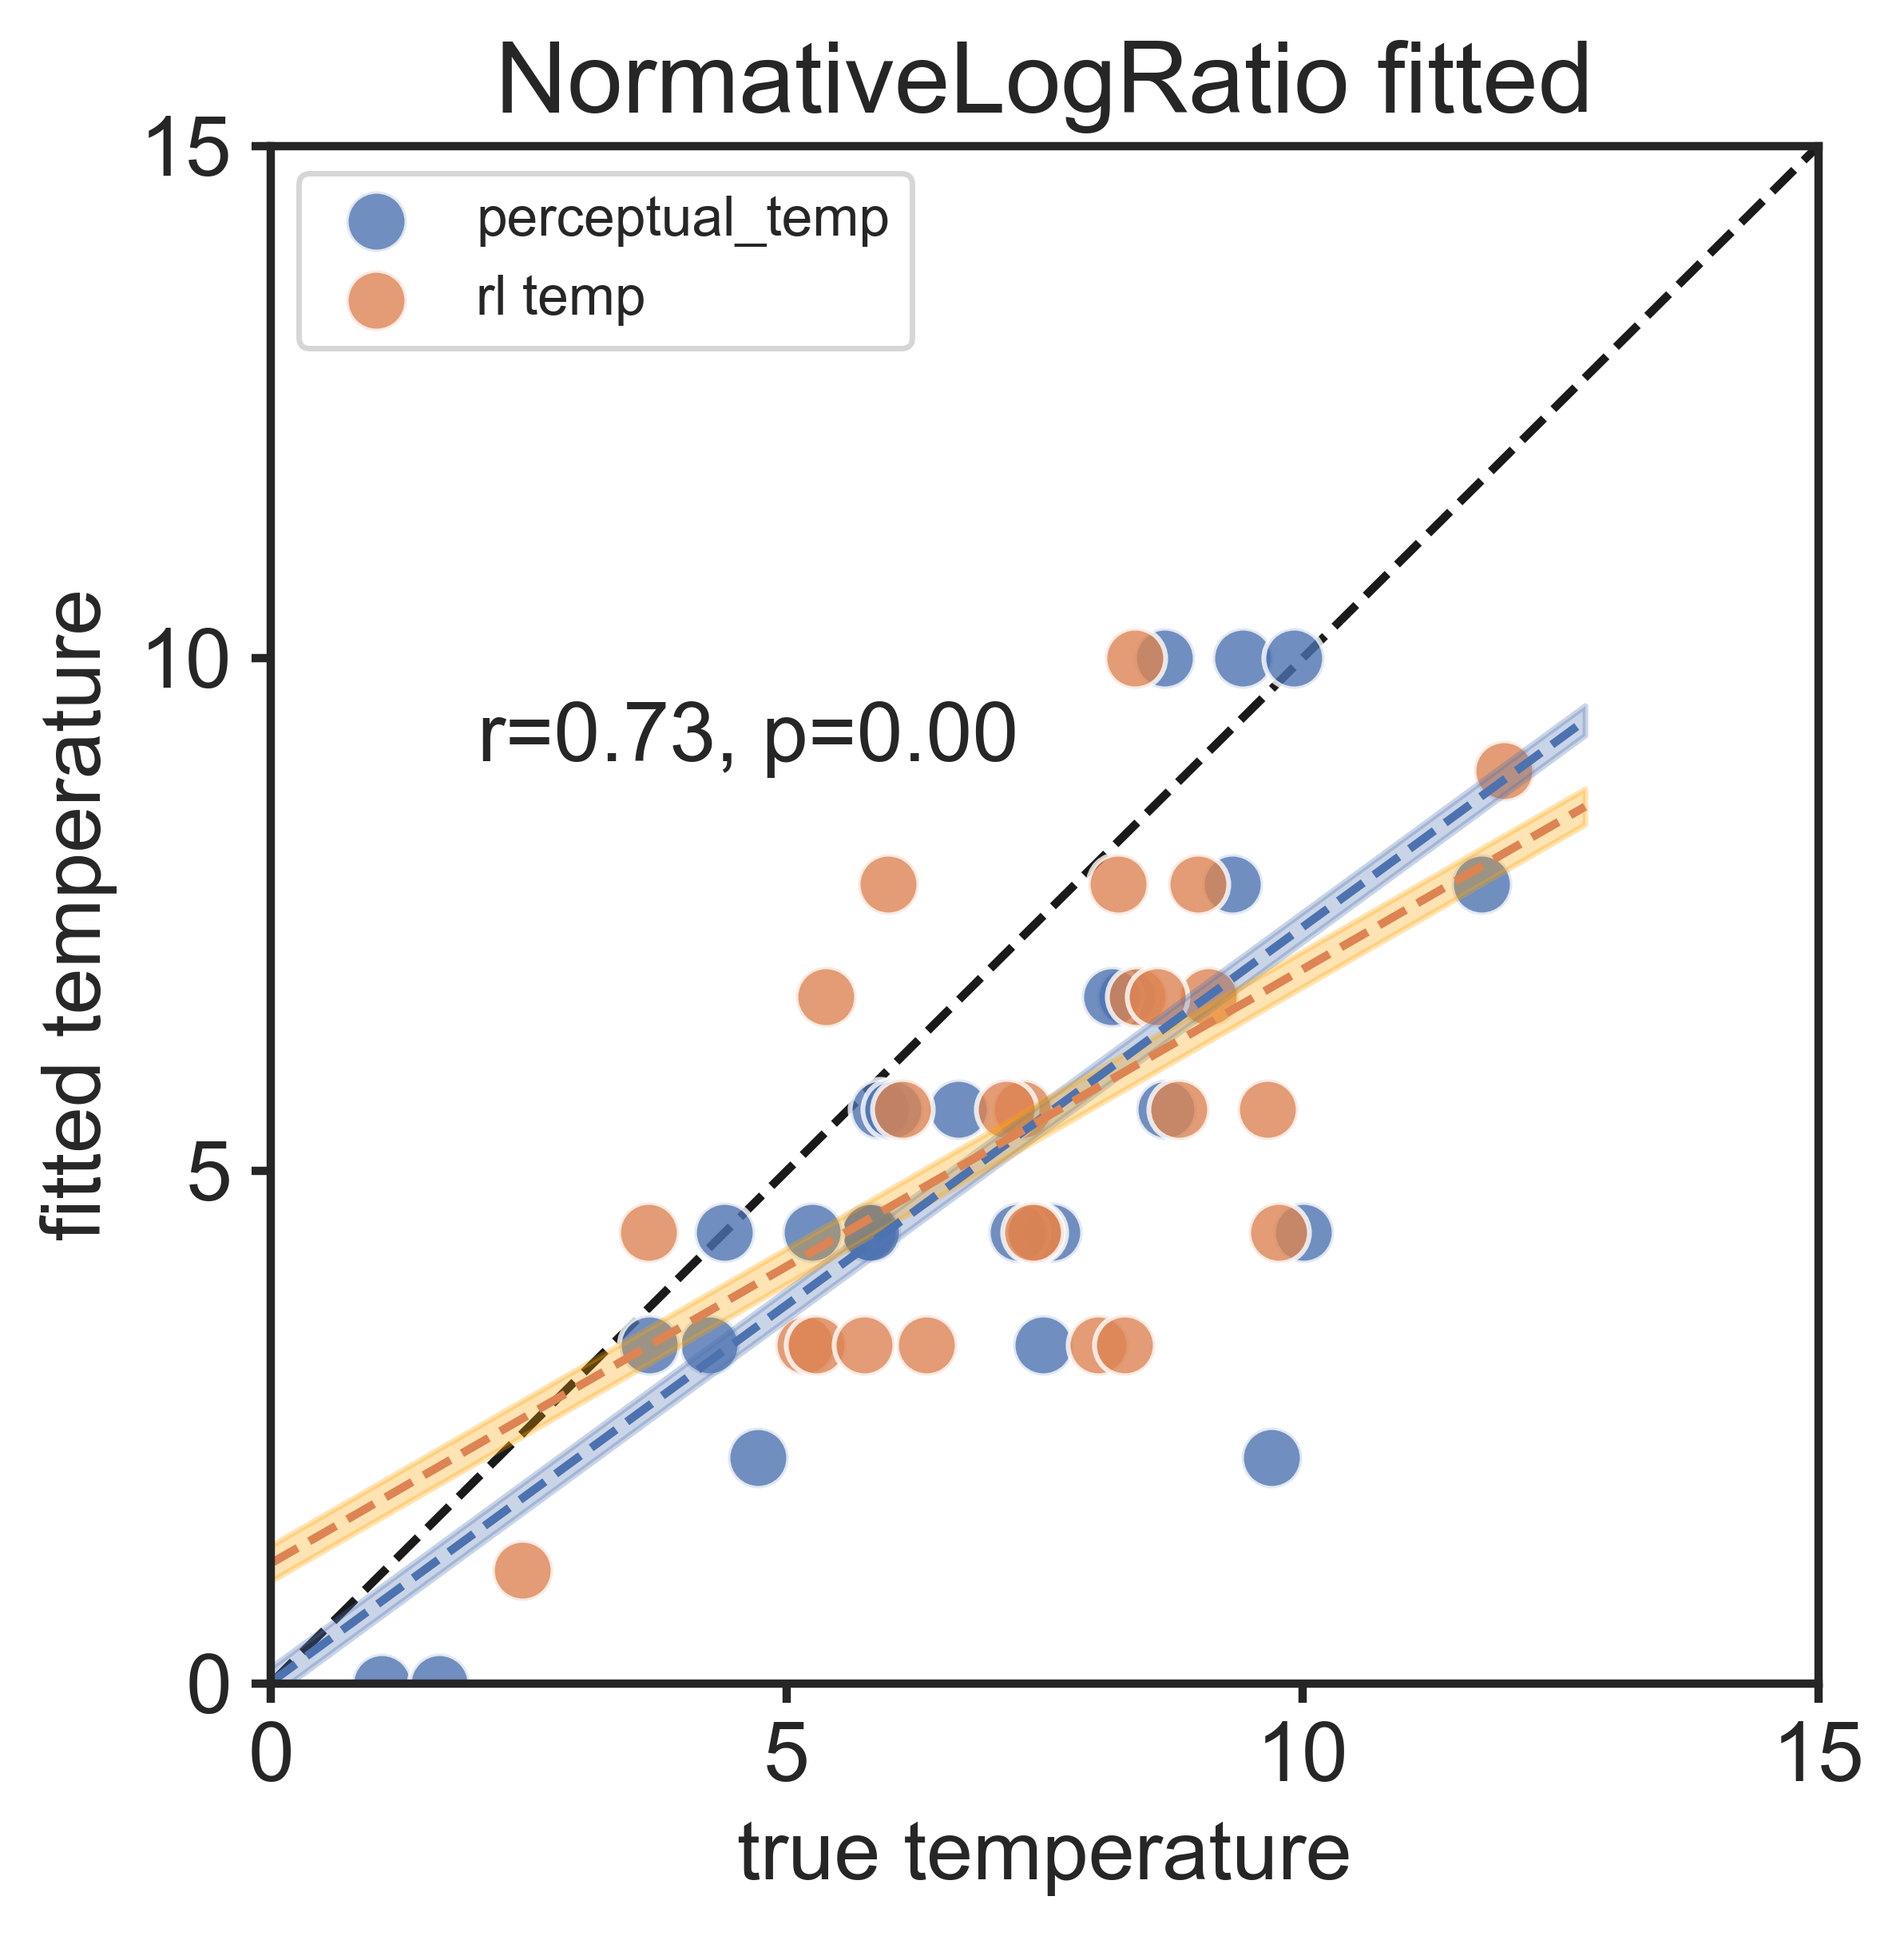

In [ ]:
#same for logratio
plt.figure(figsize=(5, 5), dpi=500)
d2 = d[(d.model=='NormativeLogRatio') & (d.original_model=='NormativeLogRatio')]
sns.scatterplot(x='perceptual_temp', y='fitted_perceptual_temp', data=d2, s=120, alpha=.8, label='perceptual_temp')
sns.scatterplot(x='rl_temp', y='fitted_rl_temp', data=d2, s=120, alpha=.8, label='rl temp')
# plot identity line by finding min and max + 1
max_ = max(d2['perceptual_temp'].max(), d2['fitted_perceptual_temp'].max()) + 1
plt.plot([0, 15], [0, 15], color='k', linestyle='--', zorder=-1)
plt.legend()
plt.title('NormativeLogRatio fitted')
plt.xlabel('true temperature')
plt.ylabel('fitted temperature')
plt.ylim([0, 15])
plt.xlim([0, 15])
# put same yticls and xticks labels
plt.yticks(np.arange(0, 16, 5))
plt.xticks(np.arange(0, 16, 5))

# add linear regression, confidence interval and pearson r
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(d2['perceptual_temp'], d2['fitted_perceptual_temp'])
plt.plot([0, max_], [intercept, max_*slope+intercept], color='C0', linestyle='--')
# plot confidence interval
plt.fill_between([0, max_], [intercept-std_err, max_*slope+intercept-std_err], [intercept+std_err, max_*slope+intercept+std_err], alpha=.3, color='b')

# same for rl temp
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(d2['rl_temp'], d2['fitted_rl_temp'])
plt.plot([0, max_], [intercept, max_*slope+intercept], color='C1', linestyle='--')
# plot confidence interval
plt.fill_between([0, max_], [intercept-std_err, max_*slope+intercept-std_err], [intercept+std_err, max_*slope+intercept+std_err], alpha=.3, color='orange')

# pearson r
from scipy.stats import pearsonr
r, p = pearsonr(d2['perceptual_temp'].dropna(), d2['fitted_perceptual_temp'].dropna())
plt.text(2, 9, f'r={r:.2f}, p={p:.2f}', fontdict={'fontsize': 15})


# plot identity
# plt.plot([0, 10], [0, 15], color='k', linestyle='--')

In [ ]:
# data frame to store the results
dfsim = []
# define progress bar
pbar = tqdm(total=nagents*len(models))

# model parameters
normative_param1 = dict(delta_prior=.2, slope_prior=true_slope, temp=10, x=ff_values, leak=0)
normative_param2 = dict(delta_prior=.2, slope_prior=true_slope, rl_temp=1e2, perceptual_temp=1e4, 
x=ff_values, leak=0)

hybrid_param = dict(perceptual_temp=1e6, perceptual_model='logit', x=ff_values,
    lr=.5, rl_temp=1e6, n_states=2, n_actions=2, q0=np.mean(blocks))

params = (normative_param1, normative_param2, {})
models = (NormativeEV, NormativeLogRatio, RandomModel)

# -----------------------------------------------------------------
# RUN
# -----------------------------------------------------------------
agent_id = 0
for agent in range(nagents):
    for model, param in zip(models, params):
        
        d = d[d.agent==agent]

        p_temp = d.fitted_perceptual_temp.values[0]
        rl_temp = d.fitted_rl_temp.values[0]
        temp = d.fitted_temp.values[0]

        param.update({'perceptual_temp': p_temp, 'rl_temp': rl_temp})
        param.update({'temp': temp})
        
        m = model(**param)

        df2 = df[df.agent==agent]
        s = df2.s.values
        ff1, ff2, ffp1, ffp2 = \
            df2.ff1.values, df2.ff2.values, df2.ffp1.values, df2.ffp2.values
        ntrials = df2.trial.max()

        for t in range(ntrials):
            
            # state = s = block index
            s = block_idx[t]

            # make choice
            a = m.make_choice(s, ff1[t], ff2[t])
            
            ffp_chosen = [ffp1[t], ffp2[t]][a]
            ffp_unchosen = [ffp1[t], ffp2[t]][1-a]

            ff_chosen = [ff1[t], ff2[t]][a]
            ff_unchosen = [ff1[t], ff2[t]][1-a]
            
            destroy = np.random.random() < ffp_chosen
            
            m.learn_perceptual(ff_chosen, destroy)

            r = 0
            
            if destroy:
                r = tnormrdn(blocks[s][a], std)
                m.learn_value(s, a, r)
                
            optimal_option = a==0
            optimal_ev = (ffp_chosen*blocks[s][a])  > (ffp_unchosen*blocks[s][1-a])
            optimal_ff = ffp_chosen >= ffp_unchosen

            cumulative_reward += r

            dfsim.append(
                {
                    'temp': param.get('temp'),
                    'perceptual_temp': param.get('perceptual_temp'),
                    'rl_temp': param.get('rl_temp'),
                    'ff1': ff1[t],
                    'ff2': ff2[t],
                    'ffp1': ffp1[t],
                    'ffp2': ffp2[t],
                    'trial': t,
                    'model': str(model.__name__),
                    'agent': agent_id,
                    's': s,
                    'a': a,
                    'r': r,
                    'optimal_option': optimal_option,
                    'optimal_ev': optimal_ev,
                    'optimal_ff': optimal_ff,
                    'choice': ff[a],
                    'params': m.get_params(s=s),
                    'destroy': destroy,
                    'cumulative_reward': cumulative_reward
                }
            )
            
        pbar.update()

dfsim = pd.DataFrame(dfsim)
# unpack parameters
# tqdm.pandas()

# refresh progress bar
pbar.refresh()
print('done')

In [ ]:
# example of using scipy.optimize.minimize
import numpy as np
from scipy.optimize import minimize

def rosen(x, *args):
    """The Rosenbrock function"""
    print(args)
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
args = (1, 2, 3, 4)
res = minimize(rosen, x0, args=args, method='BFGS', options={'disp': True})

In [ ]:
sns.set({'figure.figsize': (12, 8)})
sns.set_style('ticks')

plt.subplot(1, 2, 1)
# plot dotted line at .5
plt.plot([0, 2], [.5, .5], color='grey', linestyle=':')
avg = df.groupby(['agent', 'model'], as_index=False).mean()
new_df = pd.DataFrame({'score': np.array([avg['optimal_option'], avg['optimal_ff'], avg['optimal_ev']]).flatten(), 'type': np.array(
    ['option',] * len(avg['optimal_option'])
    + ['forcefield',] * len(avg['optimal_ff'])
    + ['forcefield * option',] * len(avg['optimal_ev'])).flatten(),
    'model':np.array([avg['model'], avg['model'], avg['model']]).flatten()})

# replace barplot by distplot with dots
ax = sns.barplot(x='type', y='score', data=new_df,alpha=.5, zorder=0, hue='model', dodge=True)
plt.legend([],[], frameon=False)
sns.stripplot(x='type', y='score', data=new_df, hue='model', jitter=True, alpha=.8, size=8, zorder=1, dodge=True)
plt.ylabel('p(optimal)')
plt.xlabel('var')
plt.xticks([0, 1, 2], ['option', 'forcefield', 'forcefield * option'])
plt.ylim(0, 1)


plt.subplot(1,2, 2)
# plot dotted line at .5
# plt.plot([0, 2], [.5, .5], color='grey', linestyle=':')

last_trial = df[df['trial'] == df['trial'].max()]

ax = sns.barplot(x='model', y='cumulative_reward', data=last_trial, alpha=.5, zorder=0, width=.5)
sns.stripplot(x='model', y='cumulative_reward', data=last_trial, hue='model', jitter=.2, alpha=.8, size=8, zorder=1)
plt.show()

import pingouin as pg
pg.ttest(df[df['model'] == 'LogitRLEV']['cumulative_reward'], df[df['model'] == 'NormativeEV']['cumulative_reward'])



In [ ]:
sns.set({'figure.figsize': (18, 8)})
sns.set_style('ticks')

plt.subplot(2, 3, 1)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_rl', hue='model', data=df)
plt.ylabel('p(choose best option)')
plt.ylim(0, 1 )

plt.subplot(2, 3, 2)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_ff', data=df)
plt.ylabel('p(choose best forcefield)')
plt.ylim(0, 1 )

plt.subplot(2, 3, 4)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_full', data=df)
plt.ylabel('p(choose best forcefield + option)')
plt.ylim(0, 1 )

plt.subplot(2, 3, 5)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='choice', data=df)
plt.ylabel('choice (option A = 0 ; option B = 1)')
plt.ylim(0, 1 )

plt.subplot(1, 3, 3)
# plot dotted line at .5
plt.plot([0, 3], [.5, .5], color='grey', linestyle=':')
avg = df.groupby('agent').mean()
# 1s column = score, 2nd colum type ('rl', 'ff', 'full')
new_df = pd.DataFrame({'score': np.array([avg['correct_rl'], avg['correct_ff'], avg['correct_full']]).flatten(), 'type': np.array(
    ['option',] * len(avg['correct_rl'])
    + ['forcefield',] * len(avg['correct_ff'])
    + ['forcefield + option',] * len(avg['correct_full'])).flatten()})

sns.barplot(x='type', y='score', data=new_df,alpha=.5, zorder=0)
sns.stripplot(x='type', y='score', data=new_df, hue='type', jitter=.2, alpha=.8, size=8, zorder=1)
plt.ylabel('p(choose best var)')
plt.xlabel('var')
plt.xticks([0,1,2], ['option', 'forcefield', 'forcefield + option'])
plt.ylim(0,1)



In [ ]:
#plot the distribution of model parameters
sns.set({'figure.figsize':(11,8)})
sns.set_style('ticks')

params = pd.DataFrame(
    {
        'param': np.array(
            ['lr', ] * nagents
          + ['rl_temp', ] * nagents
          + ['perceptual_temp', ] * nagents
        ).flatten(),
        'value': np.array(
            [agent.lr for agent in agents]
          + [agent.rl_temp for agent in agents]
          + [agent.perceptual_temp for agent in agents]
        ).flatten(),
    }
)

fig, ax = plt.subplots(ncols=2, nrows=1)
print(ax)

sns.displot(
    data=params,
    x='value',
    hue='param',
    kind='kde',
    fill=True,
    palette='colorblind',
    # split distributions  into 3 layers
    # (one for each parameter)
    # to make the plot more readable
    ax=ax[0]
    
)

d = df.groupby(['agent'], as_index=False).mean()
d.drop(['trial', 'choice', 'chosen_ff', 'unchosen', 'unchosen_ff', 'agent'], axis=1, inplace=True)
# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax[1])


In [ ]:
# fig config
plt.rcParams['figure.figsize'] = [8, 5]
#  axes width * 1.5 
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5

sns.set_style('ticks')

if 'params' in df.columns:
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        df = pd.concat([df.drop(['params'], axis=1), df['params'].apply(pd.Series)], axis=1)

# plot evolution of parameters for each model
plt.figure()
sns.lineplot(x='trial', y='β', data=df[df['model']=='NormativeEV'], label='β', n_boot=0, errorbar='se')
# plot true slope
plt.plot([0, ntrials], [true_slope, true_slope], '--', color='k', label='true slope')
sns.despine(trim=True)

plt.figure()
mask = df.model == 'LogitRLEV'
sns.lineplot(x='trial', y='β', data=df[mask], label='β', n_boot=0, errorbar='se')
sns.lineplot(x='trial', y='α', data=df[mask], label='α', n_boot=0, errorbar='se')
# plot true slope
plt.plot([0, ntrials], [true_slope, true_slope], '--', color='k', label='true slope')
plt.ylabel(('value'))
sns.despine(trim=True)
plt.figure()
sns.lineplot(x='trial', y='σ', data=df[df.model=='NormativeEV'], label='σ', n_boot=0, errorbar='se')
# plot true delta (.2 & .4)
sns.lineplot(x=[0, ntrials], y=[blocks[0][0] - blocks[0][1]] * 2, ls='--', color='r', label='true σ (block 1)')
sns.lineplot(x=[0, ntrials], y=[blocks[1][0] - blocks[1][1]] * 2, ls='--', color='g', label='true σ (block 2)')
sns.despine(trim=True)